In [17]:
!nvidia-smi

Wed Dec  8 02:33:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 78%   72C    P2   347W / 350W |  13057MiB / 24267MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:21:00.0 Off |                  Off |
| 30%   

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

In [19]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

batch_size = 128


trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


Here we shall plot the number of samples in each class.\
In CIFAR100 dataset the samples are balanced at 500 samples per class.\
We will also define a function long tail that shall convert the\
balanced dataset into an unbalanced one given a dataset imbalance factor lamda.

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name"):
    classes = dataset.classes
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()

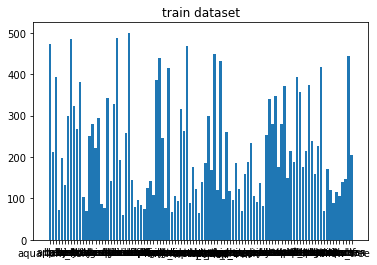

In [21]:
import random
def long_tail(dataset, lamda=1):
    num_classes = len(dataset.classes)
    class_indices = list(range(num_classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset


imabalanced_trainset = long_tail(trainset, lamda = 0.98)
show_data_distribution(imabalanced_trainset, keyname="train dataset")

In the training loop, we will be providing the optimizer, model,\
dataloader and the criterion i.e the loss function. We shall\
calculate a running loss that averages over the entire epoch and logs the same

In [22]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            pass

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss = (running_loss*i + loss.item())/(i + 1)

    print("Finished Training Epoch :", epoch, " With the running loss : ", running_loss)
    return net

In [23]:
def test(testloader, net):
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        else:
            pass

        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).cpu().detach().numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In the following function we shall feed all the outputs and the labels\
and the get metrics function shall return the following metrics of performance\
1. precision score class wise
2. max precision accross all class epochwise
3. min precision accross all class epochwise
4. mean precision *unweighted
5. recall score class wise
6. max recall accross all class epochwise
7. min recall accross all class epochwise
8. mean recall *unweighted
8. accuracy accross all class epochwise

In [24]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }

In [25]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=50):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_log(logs, lamda, classes, num_classes=10):
    precision = [x['precision'] for x in logs]
    recall = [x['recall'] for x in logs]
    accuracy = [x['accuracy'] for x in logs]

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    plt.plot(list(range(len(max_precision))), max_precision, label = "max_precision")
    plt.plot(list(range(len(min_precision))), min_precision, label = "min_precision")
    plt.plot(list(range(len(mean_precision))), mean_precision, label = "mean_precision")

    plt.plot(list(range(len(max_recall))), max_recall, label = "max_recall")
    plt.plot(list(range(len(min_recall))), min_recall, label = "min_recall")
    plt.plot(list(range(len(mean_recall))), mean_recall, label = "mean_recall")

    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title(' min mean and max precision and recalls for class imbalance rate  '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()


    precision = np.array(precision)
    recall = np.array(recall)
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), precision[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Precision classwise')
    plt.title('Class wise precision for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

    for i in range(num_classes):
        plt.plot(list(range(len_logs)), recall[:, i].tolist(), label = classes[i])

    plt.xlabel('Epochs')
    plt.ylabel('Recall classwise')
    plt.title('Class wise recall for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(list(range(len(accuracy))), accuracy, label = "accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Class wise accuracy for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

In [27]:
class Resnet18cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet18', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        self.fc = torch.nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 512))
        x = self.fc(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


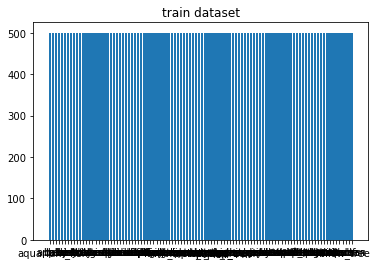

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


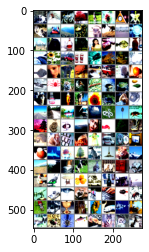

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


cattle spider  crab maple_tree kangaroo sunflower clock orchid  wolf lawn_mower mountain snake cattle dinosaur castle turtle castle chimpanzee bottle oak_tree woman   can flatfish  baby dolphin sunflower pickup_truck   can   ray maple_tree tractor hamster flatfish   boy kangaroo  crab   bed pickup_truck porcupine orange shrew  crab tiger  wolf caterpillar turtle turtle  pear  wolf bottle bottle raccoon sunflower shrew  seal telephone  road  road trout train cloud snake palm_tree cockroach pine_tree snake cockroach   sea   man sweet_pepper maple_tree snake porcupine hamster keyboard bridge  girl   bus clock television  pear shark  crab pine_tree kangaroo  lamp  lion mountain plain forest   bed cattle kangaroo leopard wardrobe  crab  baby lawn_mower table orange pickup_truck bottle house rocket dinosaur  tank trout raccoon bicycle keyboard cockroach   bee beetle   bus   cup squirrel sunflower aquarium_fish dolphin aquarium_fish kangaroo beetle spider trout mushroom  wolf squirrel squirre

Finished testing
Finished Training Epoch : 80  With the running loss :  0.46024714200697897
Finished testing
Finished Training Epoch : 81  With the running loss :  0.4489180100390978
Finished testing
Finished Training Epoch : 82  With the running loss :  0.43538970486892153
Finished testing
Finished Training Epoch : 83  With the running loss :  0.42019565007113435
Finished testing
Finished Training Epoch : 84  With the running loss :  0.4223787161852699
Finished testing
Finished Training Epoch : 85  With the running loss :  0.40044397485378136
Finished testing
Finished Training Epoch : 86  With the running loss :  0.3914940098057624
Finished testing
Finished Training Epoch : 87  With the running loss :  0.3879969080771938
Finished testing
Finished Training Epoch : 88  With the running loss :  0.3866018861760872
Finished testing
Finished Training Epoch : 89  With the running loss :  0.36443063121317615
Finished testing
Finished Training Epoch : 90  With the running loss :  0.36884492269

Finished testing
Finished Training Epoch : 185  With the running loss :  0.08284417146821609
Finished testing
Finished Training Epoch : 186  With the running loss :  0.07995001793079207
Finished testing
Finished Training Epoch : 187  With the running loss :  0.08282548563121381
Finished testing
Finished Training Epoch : 188  With the running loss :  0.08250729191352793
Finished testing
Finished Training Epoch : 189  With the running loss :  0.08172659912263337
Finished testing
Finished Training Epoch : 190  With the running loss :  0.07763344818330786
Finished testing
Finished Training Epoch : 191  With the running loss :  0.07748617365708588
Finished testing
Finished Training Epoch : 192  With the running loss :  0.07633420467243317
Finished testing
Finished Training Epoch : 193  With the running loss :  0.07879814255477664
Finished testing
Finished Training Epoch : 194  With the running loss :  0.07901426364698677
Finished testing
Finished Training Epoch : 195  With the running loss 

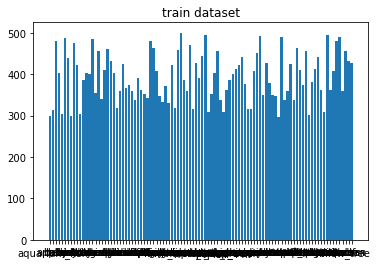

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


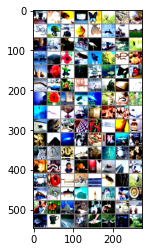

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


  bed rabbit   bee   cup butterfly spider trout forest  worm oak_tree elephant  pear mouse whale motorcycle castle   bed forest mushroom bicycle dinosaur   bus kangaroo spider otter mountain poppy hamster whale maple_tree snake  pear  pear  rose  baby bicycle tiger trout skunk motorcycle  worm pickup_truck  rose chair tiger pine_tree couch telephone skyscraper poppy   can   ray shark kangaroo woman butterfly shark lizard   cup streetcar wardrobe  lion tulip   bed cockroach  seal elephant keyboard sweet_pepper keyboard woman bottle turtle mountain shark  girl crocodile television shark chimpanzee leopard bicycle snake trout maple_tree   ray turtle possum  lion snake  baby mouse   can dolphin skyscraper lawn_mower bridge lobster chair squirrel cloud mouse  worm spider lobster shrew trout   ray bottle kangaroo   bee clock   fox butterfly   ray  wolf orchid possum  bear keyboard trout   cup train rabbit trout palm_tree  lamp willow_tree
length of trainset 39343
Finished Training Epoch : 0 

Finished testing
Finished Training Epoch : 80  With the running loss :  0.45940606799218564
Finished testing
Finished Training Epoch : 81  With the running loss :  0.45314402026789546
Finished testing
Finished Training Epoch : 82  With the running loss :  0.44330163812869555
Finished testing
Finished Training Epoch : 83  With the running loss :  0.42814807395462867
Finished testing
Finished Training Epoch : 84  With the running loss :  0.41265855724741884
Finished testing
Finished Training Epoch : 85  With the running loss :  0.41686588138728947
Finished testing
Finished Training Epoch : 86  With the running loss :  0.40334760020305577
Finished testing
Finished Training Epoch : 87  With the running loss :  0.3804629649241248
Finished testing
Finished Training Epoch : 88  With the running loss :  0.3688970885493539
Finished testing
Finished Training Epoch : 89  With the running loss :  0.3624332476552431
Finished testing
Finished Training Epoch : 90  With the running loss :  0.362119135

Finished testing
Finished Training Epoch : 169  With the running loss :  0.09909810125827791
Finished testing
Finished Training Epoch : 170  With the running loss :  0.09418838658648263
Finished testing
Finished Training Epoch : 171  With the running loss :  0.09340254250647764
Finished testing
Finished Training Epoch : 172  With the running loss :  0.0975875958933362
Finished testing
Finished Training Epoch : 173  With the running loss :  0.09321373274743361
Finished testing
Finished Training Epoch : 174  With the running loss :  0.08622406325121591
Finished testing
Finished Training Epoch : 175  With the running loss :  0.09256205199794337
Finished testing
Finished Training Epoch : 176  With the running loss :  0.09338866453013055
Finished testing
Finished Training Epoch : 177  With the running loss :  0.08455845619273644
Finished testing
Finished Training Epoch : 178  With the running loss :  0.08376352319663223
Finished testing
Finished Training Epoch : 179  With the running loss :

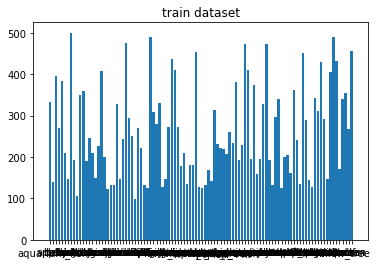

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


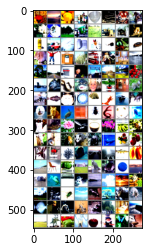

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


 crab   sea orange   can  bowl  worm tiger  bear possum plate pine_tree streetcar plain tractor turtle mouse   can pickup_truck  worm telephone cockroach telephone beetle cockroach shrew   boy wardrobe willow_tree   bus  crab table   sea pine_tree  road television   man bridge castle mountain tulip bridge chimpanzee snake crocodile   boy lawn_mower wardrobe squirrel skunk cockroach hamster plate mouse lobster cockroach dinosaur clock tiger turtle wardrobe beetle  worm plate dolphin tiger otter  rose  tank  bowl orchid sweet_pepper   bee cattle squirrel snail possum beaver whale sweet_pepper apple orchid sweet_pepper willow_tree beaver bridge skyscraper trout  pear   sea chair sweet_pepper castle raccoon beaver plate   sea porcupine turtle couch possum whale cloud palm_tree possum forest motorcycle beetle cloud skunk willow_tree possum shrew flatfish  baby  lion motorcycle leopard willow_tree   bed   sea plain dinosaur sweet_pepper squirrel apple  girl butterfly possum
length of trainse

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.8219636000838935
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.5654088995035957
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.4004303415616364
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.2674372768869575
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.1458664162486203
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.0427968244926595
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  2.9589582775153374
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  2.876573673650331
Finished testing
Finished Training Epoch : 9  With the running loss :  2.802091372948068
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.7212272111107323
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.6682137110654036
Finished testing
Finished Training Epoch : 12  With the running loss :  2.6047376651389924
Finished testing
Finished Training Epoch : 13  With the running loss :  2.526138911060258
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.4778216270839466
Finished testing
Finished Training Epoch : 15  With the running loss :  2.4262145407059594
Finished testing
Finished Training Epoch : 16  With the running loss :  2.3732395160431943
Finished testing
Finished Training Epoch : 17  With the running loss :  2.3285788952135604
Finished testing
Finished Training Epoch : 18  With the running loss :  2.2765359656483533
Finished testing
Finished Training Epoch : 19  With the running loss :  2.228414309959785
Finished testing
Finished Training Epoch : 20  With the running loss :  2.1855448946064597
Finished testing
Finished Training Epoch : 21  With the running loss :  2.136667829518225
Finished testing
Finished Training Epoch : 22  With the running loss :  2.1009208372994963
Finished testing
Finished Training Epoch : 23  With the running loss :  2.058698463673685
Finished testing
Finished Training Epoch : 24  With the running loss :  2.017517733807657
Finished testing
Fin

Finished testing
Finished Training Epoch : 105  With the running loss :  0.2528377709654616
Finished testing
Finished Training Epoch : 106  With the running loss :  0.2473837385940201
Finished testing
Finished Training Epoch : 107  With the running loss :  0.22982768429552805
Finished testing
Finished Training Epoch : 108  With the running loss :  0.22685441433214673
Finished testing
Finished Training Epoch : 109  With the running loss :  0.21994257773108342
Finished testing
Finished Training Epoch : 110  With the running loss :  0.21993890857579662
Finished testing
Finished Training Epoch : 111  With the running loss :  0.21944069164786847
Finished testing
Finished Training Epoch : 112  With the running loss :  0.21078463545178666
Finished testing
Finished Training Epoch : 113  With the running loss :  0.19949530715159342
Finished testing
Finished Training Epoch : 114  With the running loss :  0.1992607537072663
Finished testing
Finished Training Epoch : 115  With the running loss :  

Finished testing
Finished Training Epoch : 194  With the running loss :  0.0683156139052966
Finished testing
Finished Training Epoch : 195  With the running loss :  0.06414082200795997
Finished testing
Finished Training Epoch : 196  With the running loss :  0.0640443107569773
Finished testing
Finished Training Epoch : 197  With the running loss :  0.06986518741548789
Finished testing
Finished Training Epoch : 198  With the running loss :  0.0672023050651393
Finished testing
Finished Training Epoch : 199  With the running loss :  0.061569099725388446
Finished testing
Files already downloaded and verified
Files already downloaded and verified


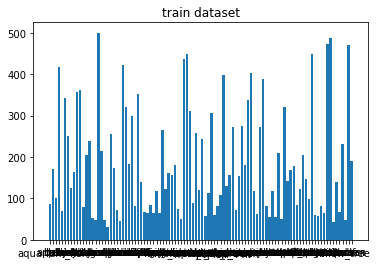

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


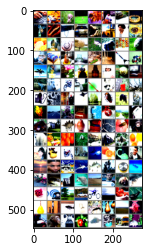

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


keyboard   bee snail rabbit   bee  girl snail  bowl   bee sweet_pepper  lamp  lamp crocodile   bus woman sunflower orange squirrel  bowl willow_tree possum skunk  pear possum chimpanzee   bed  pear bridge lizard   fox rocket motorcycle palm_tree   bee  rose   bee bottle  girl snail television dinosaur  bear motorcycle house rocket raccoon poppy willow_tree telephone snake   man chair maple_tree cockroach  bear squirrel tulip  road  bear   bed   sea lobster  road telephone house house dinosaur  pear couch  worm beetle chimpanzee  bear sweet_pepper orange possum dinosaur train   bee orange  girl  pear motorcycle house shark orange dinosaur   man   sea woman raccoon dolphin trout pine_tree clock dolphin bicycle crocodile house porcupine plain   man  bear  wolf  rose telephone oak_tree pickup_truck motorcycle plain lobster snail  pear wardrobe cockroach chair lizard  pear plain  rose trout chimpanzee telephone beetle trout raccoon   bus possum
length of trainset 18455
Finished Training Epo

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.7548681522237843
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.542792525784722
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.3860338622126087
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.2660628680525154
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.164239779834089
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.0632573127746583
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  2.9784039957769988
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  2.9168511374243384
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  2.839160138163074
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.777509870200322
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.7160957846148253
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.6591442272580905
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.6123072492665265
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.5503861854816305
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.502395217172031
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.443367676899352
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.383338924934125
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.3367876685898885
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.3055687830365943
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.2723113939679904
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.197288806685085
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  2.1526923508479676
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  2.113597372482564
Finished testing
Finished Training Epoch : 24  With the running loss :  2.0720791528964875
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  2.02178693886461
Finished testing
Finished Training Epoch : 26  With the running loss :  1.9955079596618126
Finished testing
Finished Training Epoch : 27  With the running loss :  1.947380885584601
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  1.9077663084556316
Finished testing
Finished Training Epoch : 29  With the running loss :  1.8635133644630169
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  1.8294973940684878
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  1.7950135518764627
Finished testing
Finished Training Epoch : 32  With the running loss :  1.7385305190908498
Finished testing
Finished Training Epoch : 33  With the running loss :  1.6831478373757724
Finished testing
Finished Training Epoch : 34  With the running loss :  1.6643179408435165
Finished testing
Finished Training Epoch : 35  With the running loss :  1.618493578351777
Finished testing
Finished Training Epoch : 36  With the running loss :  1.5820873827769837
Finished testing
Finished Training Epoch : 37  With the running loss :  1.5571866282101334
Finished testing
Finished Training Epoch : 38  With the running loss :  1.5312798162986492
Finished testing
Finished Training Epoch : 39  With the running loss :  1.474700281537812
Finished testing
Finished Training Epoch : 40  With the running loss :  1.4496191370076146
Finished testing
Finished Training Epoch : 41  With the running loss :  1.4151063647763482
Finished testing
F

Finished testing
Finished Training Epoch : 121  With the running loss :  0.17311846256769936
Finished testing
Finished Training Epoch : 122  With the running loss :  0.17627396110830637
Finished testing
Finished Training Epoch : 123  With the running loss :  0.1826201496966954
Finished testing
Finished Training Epoch : 124  With the running loss :  0.1730202638383569
Finished testing
Finished Training Epoch : 125  With the running loss :  0.1849618643008429
Finished testing
Finished Training Epoch : 126  With the running loss :  0.16798558047619358
Finished testing
Finished Training Epoch : 127  With the running loss :  0.16866480045277502
Finished testing
Finished Training Epoch : 128  With the running loss :  0.1608546791919347
Finished testing
Finished Training Epoch : 129  With the running loss :  0.1525488616063677
Finished testing
Finished Training Epoch : 130  With the running loss :  0.15024812591486958
Finished testing
Finished Training Epoch : 131  With the running loss :  0.

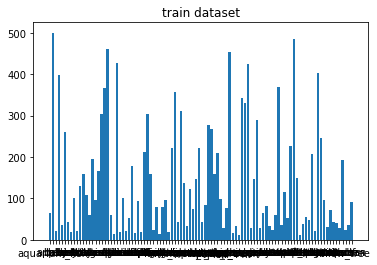

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


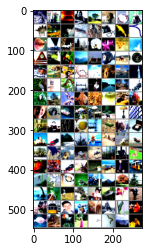

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


lizard streetcar   bed woman pine_tree  lion plate  bear dinosaur butterfly possum caterpillar skunk telephone aquarium_fish  worm   ray bridge skunk castle orchid orchid  lion rocket clock caterpillar butterfly mountain castle possum camel clock cattle tiger tractor clock  bear  lion maple_tree rocket possum   can caterpillar bridge clock  road crocodile lawn_mower possum pine_tree snake flatfish tiger apple butterfly maple_tree  girl skunk aquarium_fish otter mushroom elephant  lamp keyboard   fox flatfish  worm  bowl bridge caterpillar cattle clock castle lawn_mower oak_tree pine_tree  baby squirrel crocodile otter maple_tree shrew possum aquarium_fish possum forest leopard rabbit aquarium_fish tiger lawn_mower snail squirrel lobster   man streetcar spider squirrel flatfish squirrel lawn_mower mountain oak_tree pine_tree whale lizard cattle pine_tree   boy aquarium_fish orchid cattle elephant streetcar   boy flatfish forest pine_tree caterpillar streetcar flatfish pine_tree aquarium

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.6440136760746666
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.4361917163253923
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.289680205353903
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.198689029851091
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.095192156800436
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.016962012019725
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  2.936990070780483
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  2.862825437423286
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  2.806219886202331
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.7441407474902793
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.677385953588224
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.623778970963363
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.5568046460457894
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.5051284645675516
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.4468934164134732
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.406836140046425
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.367909549573145
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.306594660522742
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.259754455417668
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.2151173189145723
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.1660597925886105
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  2.113487589249917
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  2.0705186095806423
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  2.0399086595675255
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  1.995091892163688
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  1.9441209090959042
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  1.913830591997969
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  1.8725537608522889
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  1.837113808054443
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  1.7786195901555752
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  1.7411552295772308
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  1.7112527484193853
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  1.6714699202721273
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  1.6243643191976285
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  1.5975710273882664
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  1.5597037569098515
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  1.507643249056755
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  1.4764828167924093
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  1.44750117161952
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  1.4059948680597705
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  1.3962690272462477
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.3466047628210231
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  1.3157730102539065
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  1.2794531682215697
Finished testing
Finished Training Epoch : 45  With the running loss :  1.2370193037418054
Finished testing
Finished Training Epoch : 46  With the running loss :  1.2045114352068773
Finished testing
Finished Training Epoch : 47  With the running loss :  1.1667746666374552
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  1.1278490724913572
Finished testing
Finished Training Epoch : 49  With the running loss :  1.0927348038472169
Finished testing
Finished Training Epoch : 50  With the running loss :  1.0680034904305002
Finished testing
Finished Training Epoch : 51  With the running loss :  1.0224864318830151
Finished testing
Finished Training Epoch : 52  With the running loss :  0.9958270831939278
Finished testing
Finished Training Epoch : 53  With the running loss :  0.9819739548438186
Finished testing
Finished Training Epoch : 54  With the running loss :  0.9532393643615442
Finished testing
Finished Training Epoch : 55  With the running loss :  0.913202359588868
Finished testing
Finished Training Epoch : 56  With the running loss :  0.8917060560042706
Finished testing
Finished Training Epoch : 57  With the running loss :  0.8743901252746582
Finished testing
Finished Training Epoch : 58  With the running loss :  0.8359292012835862
Finished testing


Finished testing
Finished Training Epoch : 138  With the running loss :  0.11603392797325729
Finished testing
Finished Training Epoch : 139  With the running loss :  0.10759339696907122
Finished testing
Finished Training Epoch : 140  With the running loss :  0.10640890725435467
Finished testing
Finished Training Epoch : 141  With the running loss :  0.10721253238003188
Finished testing
Finished Training Epoch : 142  With the running loss :  0.10157885019658902
Finished testing
Finished Training Epoch : 143  With the running loss :  0.11362195701910816
Finished testing
Finished Training Epoch : 144  With the running loss :  0.10176116740758266
Finished testing
Finished Training Epoch : 145  With the running loss :  0.10038785721867456
Finished testing
Finished Training Epoch : 146  With the running loss :  0.09989023926334643
Finished testing
Finished Training Epoch : 147  With the running loss :  0.10203617336143044
Finished testing
Finished Training Epoch : 148  With the running loss 

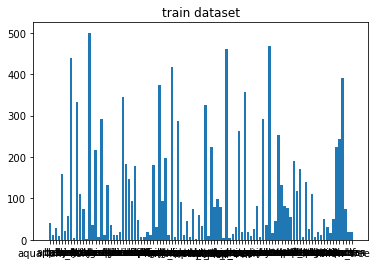

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


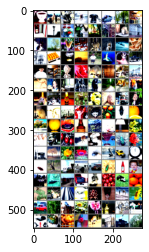

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


  cup camel  seal  seal telephone pickup_truck maple_tree table bottle  lamp  rose beetle house forest possum castle otter maple_tree butterfly table  wolf squirrel whale mushroom house orange   cup willow_tree   boy turtle possum pickup_truck   boy table possum  rose possum wardrobe mushroom castle camel  girl table  seal chimpanzee  road   fox hamster hamster table bottle mushroom  rose beaver   bus mushroom squirrel dinosaur couch lobster possum orange cockroach orange maple_tree orange poppy bottle willow_tree hamster  lamp orchid couch  seal apple   fox mushroom   cup beetle poppy telephone willow_tree poppy poppy cockroach skunk pickup_truck clock cockroach kangaroo castle cattle   bus beetle bottle  baby  tank  seal train pickup_truck skunk apple skunk orange telephone   fox skyscraper  lamp  crab possum camel sunflower pickup_truck willow_tree beetle sunflower orchid  lamp squirrel camel pickup_truck beetle orange  rose kangaroo castle rocket willow_tree
length of trainset 1102

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.4576689265240197
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.227561657456145
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.0480467478434257
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  2.934460618030065
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  2.8424680781090395
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  2.7674522290284607
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  2.699811834028398
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  2.625553366781651
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  2.5650778995163135
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.494168503531095
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.447332530186093
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.378764138824638
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.3546161076118195
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.3013765784515727
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.25096349743591
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.2090433904494358
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.1483355226187864
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.1196636961794444
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.0814522052633357
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.0397313614001225
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.0034640219019746
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  1.9544983170498376
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  1.913960600721425
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  1.886343084532639
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  1.8445796884339432
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  1.7984784348257656
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  1.7616226070228664
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  1.7229067717475453
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  1.6932243382793732
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  1.6655358500864315
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  1.622287987292498
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  1.5938703534246865
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  1.5606790068505825
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  1.5054240678918773
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  1.4885113664057064
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  1.4608895216865108
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  1.420373708352275
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  1.4017769810797152
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  1.3501089167320868
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  1.3277693767657224
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  1.2996499798763756
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.267007626336196
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  1.2336673613252311
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  1.188191646131976
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  1.1439915504948845
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 46  With the running loss :  1.1465444455201594
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 47  With the running loss :  1.117190518598447
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  1.07918660668121
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 49  With the running loss :  1.0451289833277122
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 50  With the running loss :  1.0308980140192754
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 51  With the running loss :  1.0064703959158097
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 52  With the running loss :  0.9489200745505848
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 53  With the running loss :  0.9250534711212948
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 54  With the running loss :  0.9110978047053019
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 55  With the running loss :  0.9119051907254362
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 56  With the running loss :  0.8617223350481055
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 57  With the running loss :  0.8473106913868038
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 58  With the running loss :  0.8110183792552731
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 59  With the running loss :  0.793134361162953
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 60  With the running loss :  0.7785310409534938
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 61  With the running loss :  0.7751306309097115
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 62  With the running loss :  0.747236118919548
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 63  With the running loss :  0.7320383472004156
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 64  With the running loss :  0.7184140079322903
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 65  With the running loss :  0.7034275069318973
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 66  With the running loss :  0.6875553668915538
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 67  With the running loss :  0.6500945289929704
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 68  With the running loss :  0.6325809078655027
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 69  With the running loss :  0.617019731765506
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 70  With the running loss :  0.5861559869914218
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 71  With the running loss :  0.5664833475803508
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 72  With the running loss :  0.568705602281395
Finished testing
Finished Training Epoch : 73  With the running loss :  0.5701825135740741
Finished testing
Finished Training Epoch : 74  With the running loss :  0.5680502478418679
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 75  With the running loss :  0.5143511082934237
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 76  With the running loss :  0.5188406808622953
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 77  With the running loss :  0.511789079712725
Finished testing
Finished Training Epoch : 78  With the running loss :  0.48202512730127095
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 79  With the running loss :  0.5079098323295856
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 80  With the running loss :  0.5202803385668787
Finished testing
Finished Training Epoch : 81  With the running loss :  0.4775934051508191
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 82  With the running loss :  0.4562004633333491
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 83  With the running loss :  0.41704083311146706
Finished testing
Finished Training Epoch : 84  With the running loss :  0.4215766105843686
Finished testing
Finished Training Epoch : 85  With the running loss :  0.4244090548191948
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 86  With the running loss :  0.40087203253274667
Finished testing
Finished Training Epoch : 87  With the running loss :  0.3818428196098613
Finished testing
Finished Training Epoch : 88  With the running loss :  0.37196776116716457
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 89  With the running loss :  0.3711654333205059
Finished testing
Finished Training Epoch : 90  With the running loss :  0.34217273812184384
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 91  With the running loss :  0.34106501234673914
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 92  With the running loss :  0.3504585262345172
Finished testing
Finished Training Epoch : 93  With the running loss :  0.31738620996475214
Finished testing
Finished Training Epoch : 94  With the running loss :  0.3476819223028491
Finished testing
Finished Training Epoch : 95  With the running loss :  0.3102089534888324
Finished testing
Finished Training Epoch : 96  With the running loss :  0.3134528864389177
Finished testing
Finished Training Epoch : 97  With the running loss :  0.30413048123491226
Finished testing
Finished Training Epoch : 98  With the running loss :  0.2941991534383817
Finished testing
Finished Training Epoch : 99  With the running loss :  0.274932887704893
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 100  With the running loss :  0.26862758124011693
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 101  With the running loss :  0.29299623887429294
Finished testing
Finished Training Epoch : 102  With the running loss :  0.2715811588983425
Finished testing
Finished Training Epoch : 103  With the running loss :  0.27861481785089115
Finished testing
Finished Training Epoch : 104  With the running loss :  0.2590274481937805
Finished testing
Finished Training Epoch : 105  With the running loss :  0.25367553292334766
Finished testing
Finished Training Epoch : 106  With the running loss :  0.24410686436398277
Finished testing
Finished Training Epoch : 107  With the running loss :  0.2507634048146763
Finished testing
Finished Training Epoch : 108  With the running loss :  0.23640317992232313
Finished testing
Finished Training Epoch : 109  With the running loss :  0.24210113115694326
Finished testing
Finished Training Epoch : 110  With the running loss :  0.24258301021723908
Finished testing
Finished Training Epoch : 111  With the running loss :  0.223441566115823

Finished testing
Finished Training Epoch : 190  With the running loss :  0.08577812619336034
Finished testing
Finished Training Epoch : 191  With the running loss :  0.0884688130697642
Finished testing
Finished Training Epoch : 192  With the running loss :  0.1115110227088819
Finished testing
Finished Training Epoch : 193  With the running loss :  0.1226776013172221
Finished testing
Finished Training Epoch : 194  With the running loss :  0.10670762453442333
Finished testing
Finished Training Epoch : 195  With the running loss :  0.09761558905586429
Finished testing
Finished Training Epoch : 196  With the running loss :  0.10631061311083276
Finished testing
Finished Training Epoch : 197  With the running loss :  0.14669109148711987
Finished testing
Finished Training Epoch : 198  With the running loss :  0.1335649338775668
Finished testing
Finished Training Epoch : 199  With the running loss :  0.1490394819913239
Finished testing


In [12]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL


# Data transforms (normalization & data augmentation)

logs_by_lamda_resnet18_cifar100_transfer_learning = []

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

runs = 10
batch_size = 128

for lamda in [1.0, 0.995, 0.985, 0.975, 0.965, 0.955]:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))
    net = Resnet18cifar(100, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=200)
    logs_by_lamda_resnet18_cifar100_transfer_learning.append({lamda: logs})

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  1.0


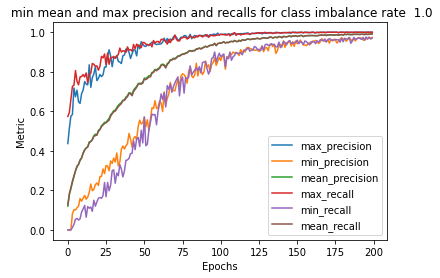

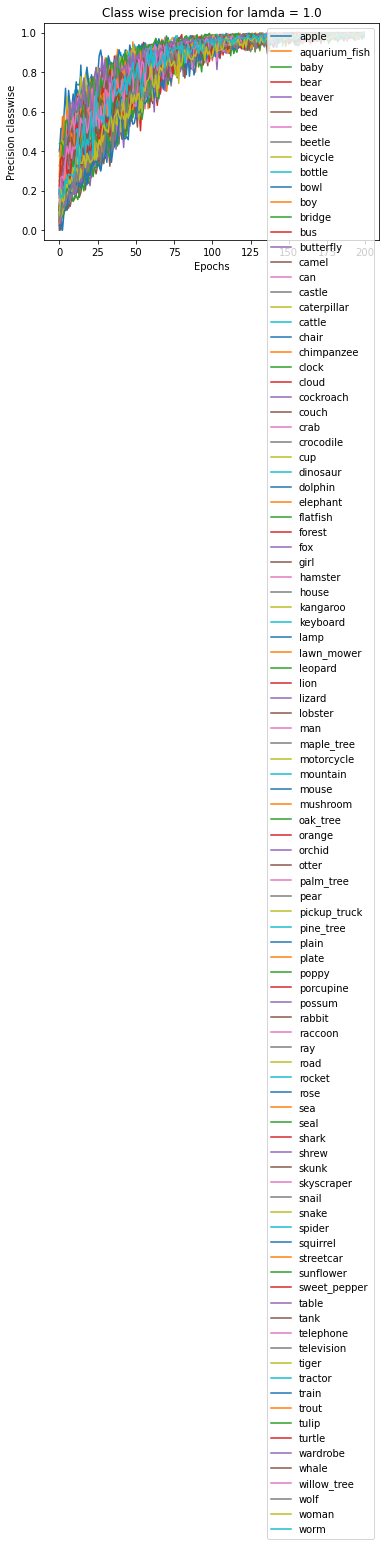

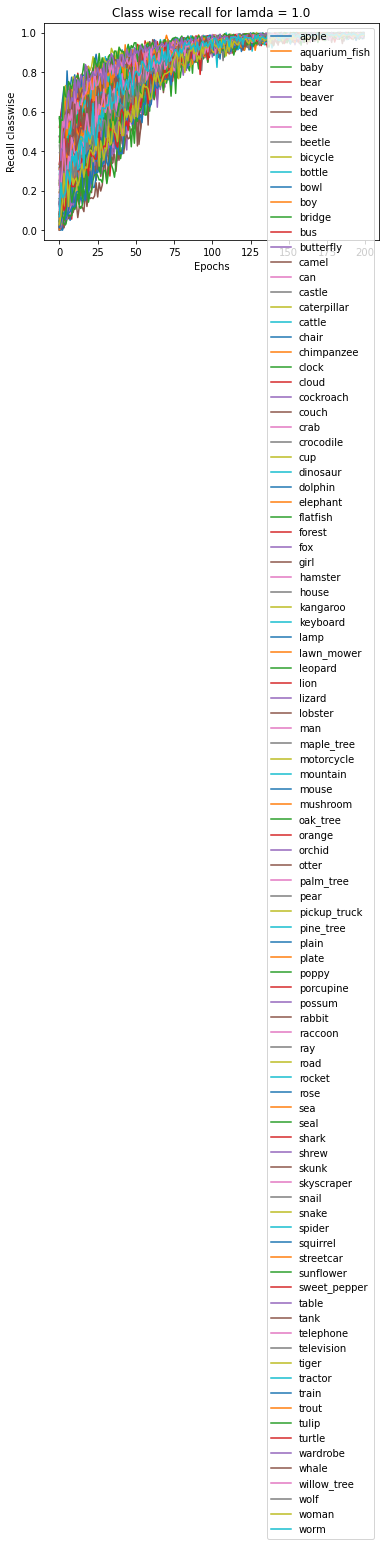

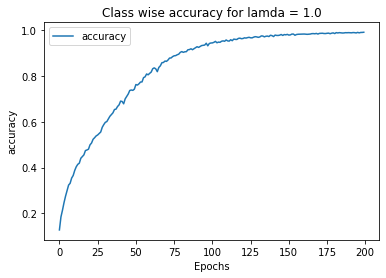

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.995


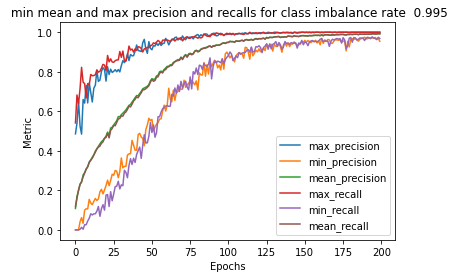

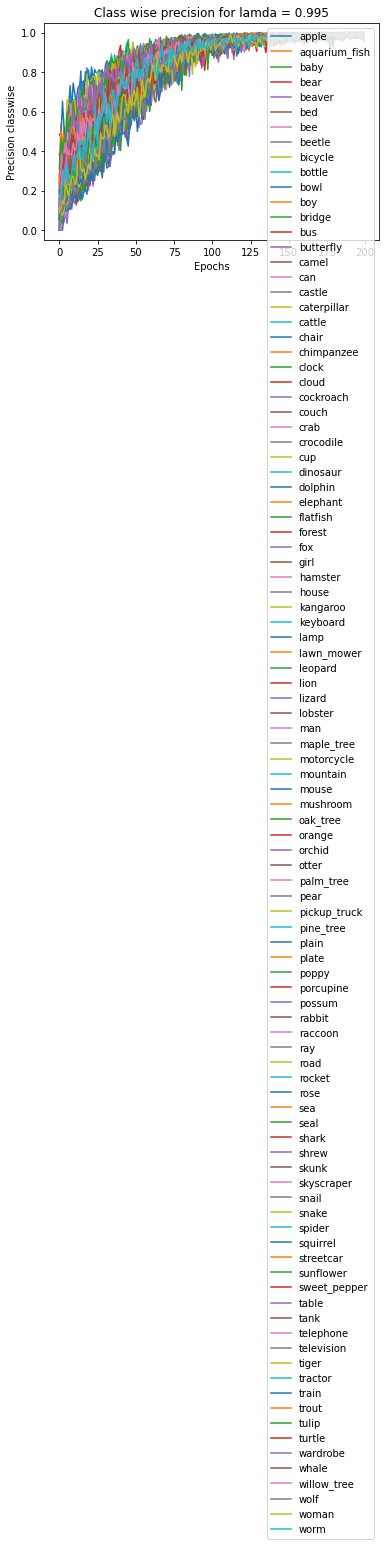

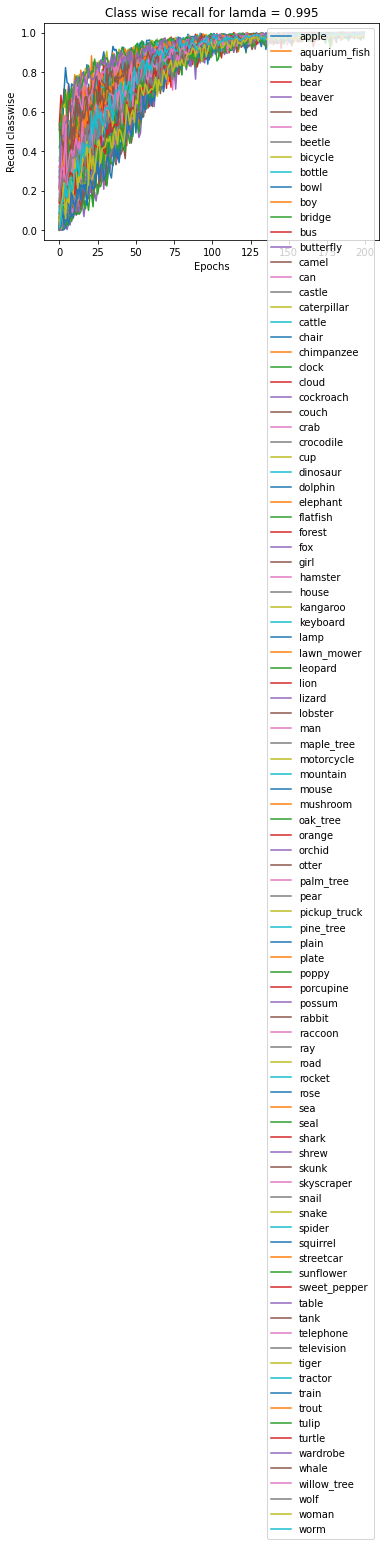

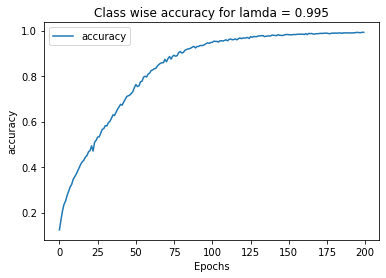

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.985


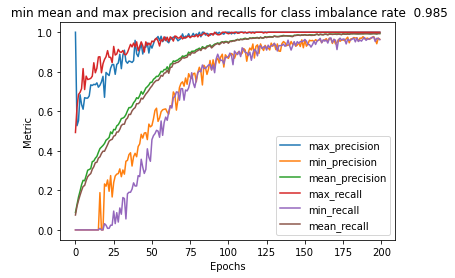

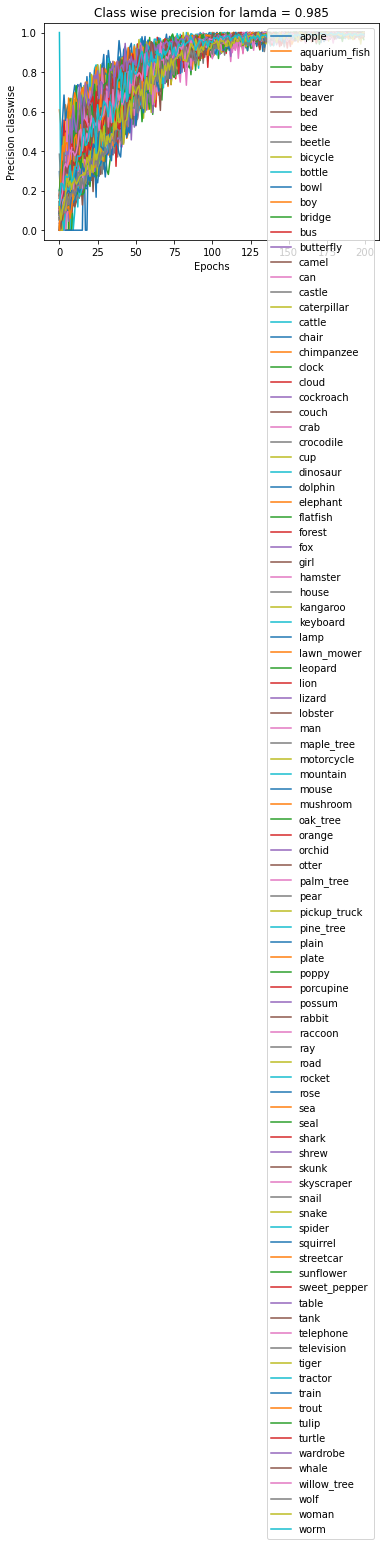

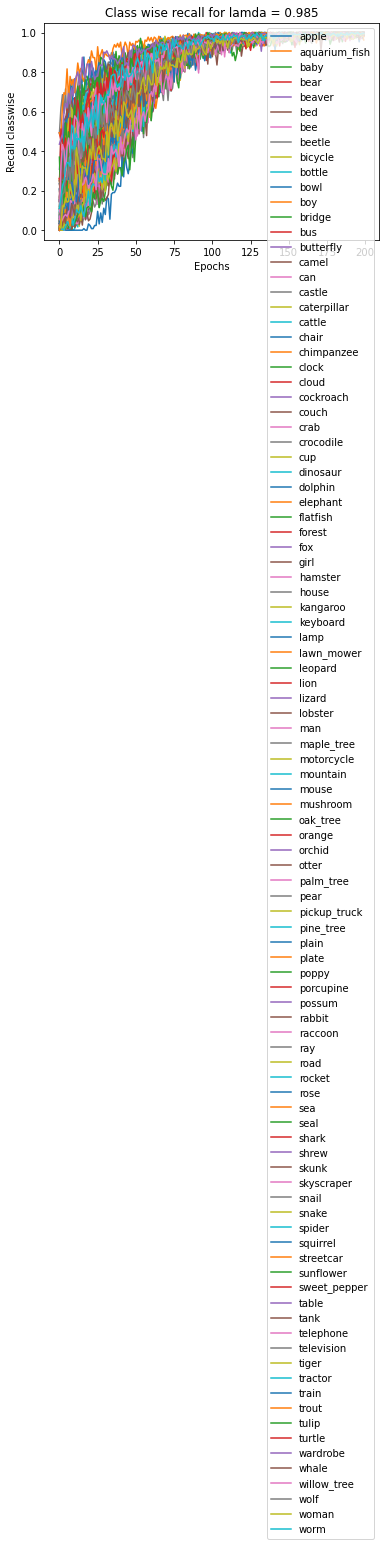

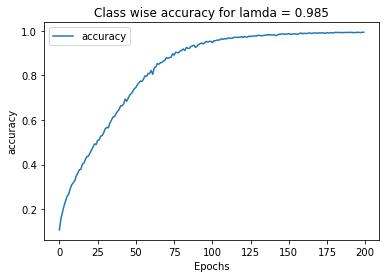

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.975


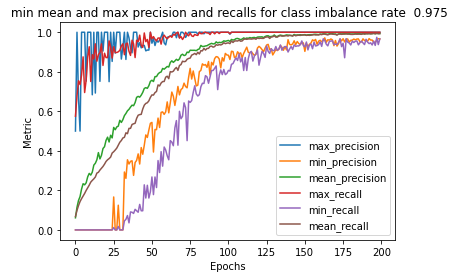

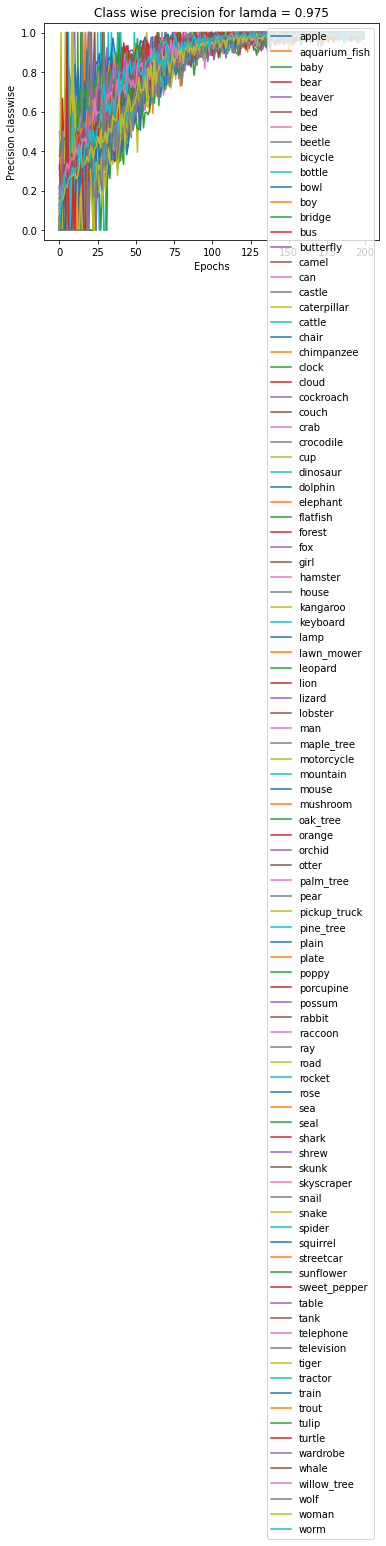

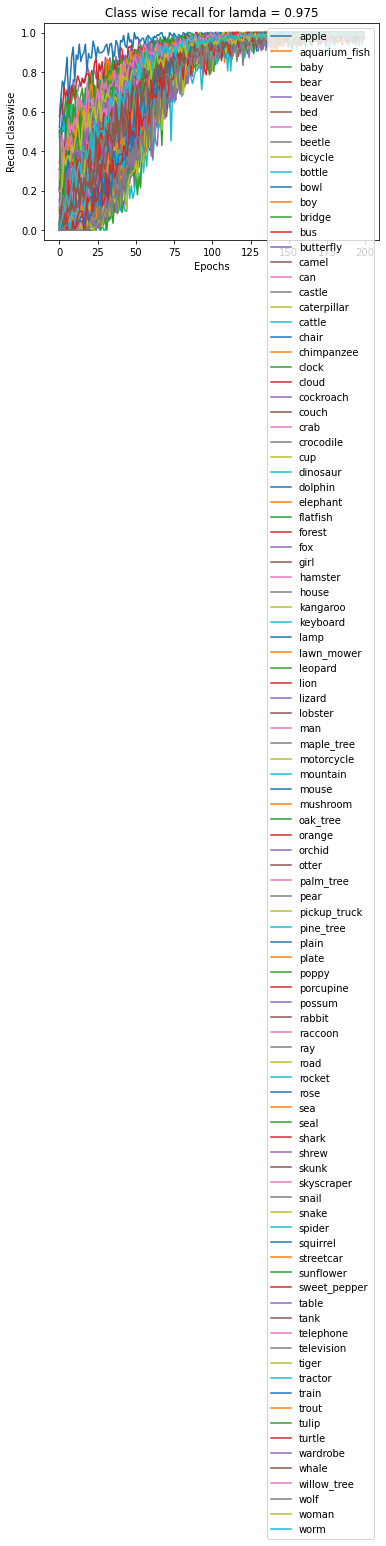

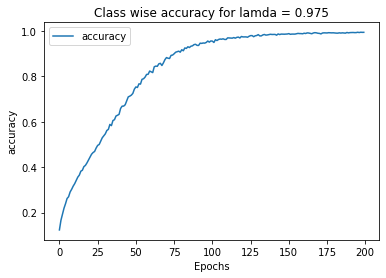

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.965


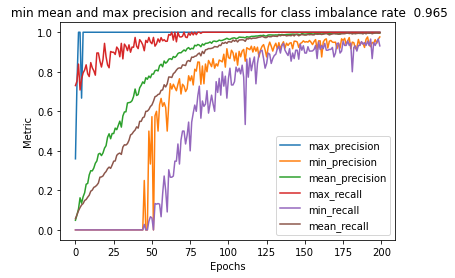

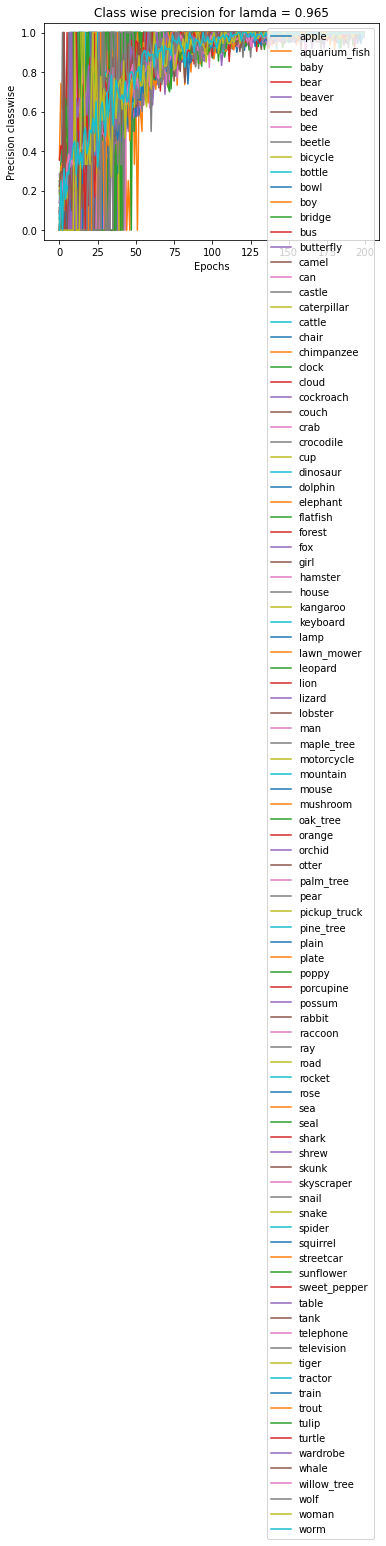

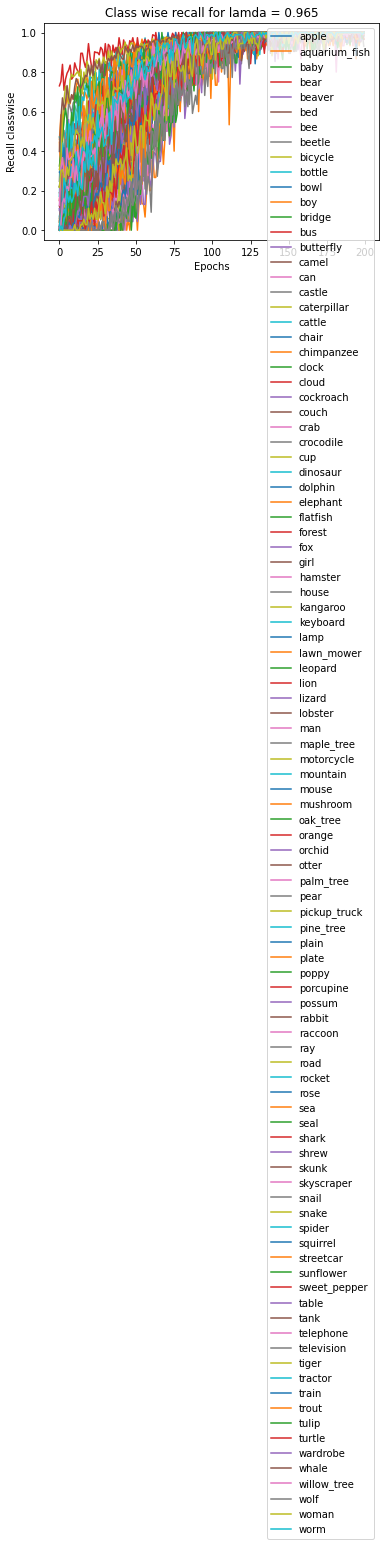

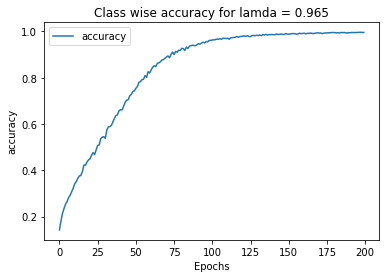

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.955


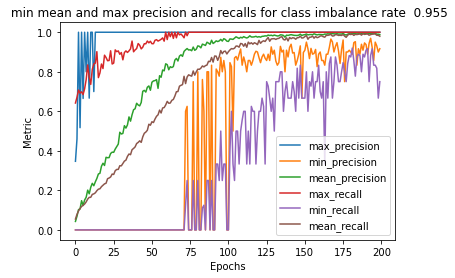

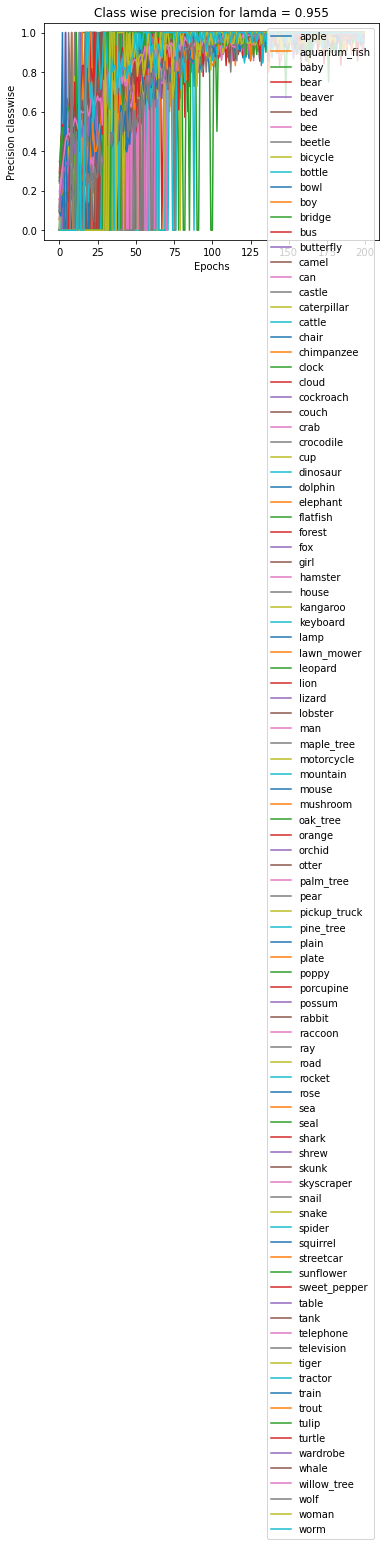

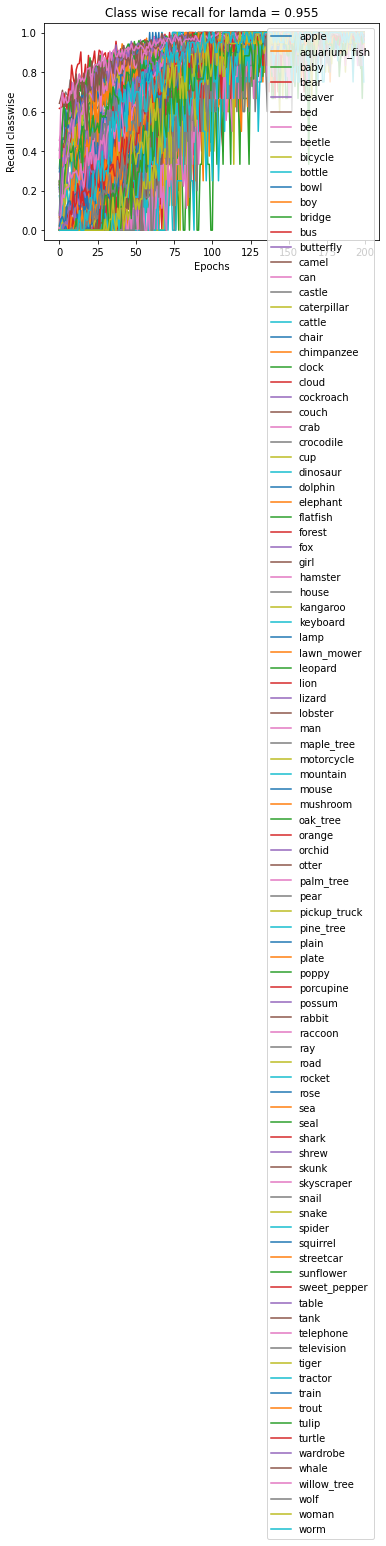

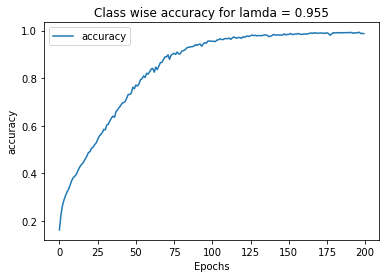

In [16]:
for log in logs_by_lamda_resnet18_cifar100_transfer_learning:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER")
    print("THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)

In [1]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar10 = []
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])



for lamda in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75]:
    batch_size = 16
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, 10, lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(10, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=200)
    logs_by_lamda_resnet18_cifar10_transfer_learning.append({lamda: logs})

/Users/shrinivas/miniconda3/envs/const_opt/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


NameError: name 'torchvision' is not defined

In [28]:
import torch.nn.functional as F

class LogitAdjustedLoss(torch.nn.Module):
    def __init__(self, priori, epsilon=0.001):
        super().__init__()
        '''
        weight (Tensor, optional) – a manual rescaling weight given to each class. 
                                    If given, has to be a Tensor of size C

        size_average (bool, optional) –     Deprecated (see reduction). By default, 
                                            the losses are averaged over each loss element 
                                            in the batch. Note that for some losses, there are 
                                            multiple elements per sample. If the field size_average
                                            is set to False, the losses are instead summed for
                                            each minibatch. Ignored when reduce is False. Default: True

        ignore_index (int, optional) –      Specifies a target value that is ignored
                                            and does not contribute to the input gradient.
                                            When size_average is True, the loss is averaged
                                            over non-ignored targets. Note that ignore_index
                                            is only applicable when the target contains class indices.

        reduce (bool, optional) –           Deprecated (see reduction). By default, the losses are
                                            averaged or summed over observations for each minibatch
                                            depending on size_average. When reduce is False, returns a
                                            loss per batch element instead and ignores size_average. Default: True

        reduction (string, optional) –      Specifies the reduction to apply to the output:
                                            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
                                            'mean': the weighted mean of the output is taken, 'sum': the
                                            output will be summed. Note: size_average and reduce are in
                                            the process of being deprecated, and in the meantime, specifying
                                            either of those two args will override reduction. Default: 'mean'

        label_smoothing (float, optional) – A float in [0.0, 1.0]. Specifies the amount of smoothing when
                                            computing the loss, where 0.0 means no smoothing. The targets 
                                            become a mixture of the original ground truth and a uniform
                                            distribution as described in Rethinking the Inception Architecture
                                            for Computer Vision. Default: 0.00.0.
        '''
        self.epsilon = epsilon
        
        # here we make sure that there is a non zero priori for even 
        # those classes which happen to have zero samples (by mistake)
        self.priori = (priori + epsilon)/torch.sum(priori + epsilon)
        self.priori.requires_grad = False
        self.CrossEntropyLoss = torch.nn.CrossEntropyLoss()
    def forward(self, x, y):
        x_logit_adjusted = x - torch.log(self.priori)
        loss = self.CrossEntropyLoss(x_logit_adjusted, y)
        return loss

In [29]:
import random 
import numpy as np
def test_loss():
    batch_size = np.random.randint(2, 3)
    pred_size = np.random.randint(5, 10)
    
    y = torch.tensor(np.random.randint(0, pred_size, batch_size))
    x = torch.randn((batch_size, pred_size))

    priori = F.softmax(torch.randn((pred_size)), dim=0)
    LA = LogitAdjustedLoss(priori=priori, epsilon = 1e-6)

    y_oh = F.one_hot(y, pred_size)
    loss_all_logits = -1*torch.log(F.softmax(x-torch.log(priori)))

    calc_LA = torch.mean(torch.sum(y_oh * loss_all_logits, dim=-1))

    if torch.abs(calc_LA - LA(x, y)) < 0.01:
        print("the calculate logit adjusted loss is within error bounds with abs difference", torch.abs(calc_LA - LA(x, y)))
    else:
        print("the estimate is too inaccurate  ", torch.abs(calc_LA - LA(x, y)))
    return 

test_loss()

the calculate logit adjusted loss is within error bounds with abs difference tensor(2.4796e-05)


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Files already downloaded and verified
Files already downloaded and verified
the per class priori is as follows
apple  :  0.0033153061235089406
aquarium_fish  :  0.009103740110148249
baby  :  0.009869963540532718
bear  :  0.005837051383296836
beaver  :  0.019616836611053574
bed  :  0.007289650115274102
bee  :  0.01007139136789053
beetle  :  0.0042248444862115235
bicycle  :  0.011838069004606213
bottle  :  0.003120339600997627
bowl  :  0.00714385711296862
boy  :  0.01635549362453871
bridge  :  0.00856836736175065
bus  :  0.005605904148518281
butterfly  :  0.0047692959576971835
camel  :  0.004311065802256657
can  :  0.020017180215360794
castle  :  0.004580431837772374
caterpillar  :  0.006201764765634257
cattle  :  0.008229060014225324
chair  :  0.006589266340591778
chimpanzee  :  0.013096356502156554
clock  :  0.018463209683630737
cloud  :  0.0048666285282624325
cockroach  :  0.013914649191829675
couch  :  0.006077729470321571
crab  :  0.008064478813940817
crocodile  :  0.005493786065547

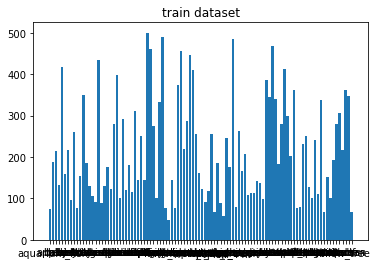

In [30]:
import random

def long_tail_priori(dataset, classes=10, lamda=1):
    class_indices = list(range(classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    priori = [x/sum(class_probs) for x in class_probs]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset, priori

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = trainset.classes


imbalanced_trainset, priori = long_tail_priori(trainset, classes=len(trainset.classes), lamda = 0.98)
print("the per class priori is as follows")
for i, elem in enumerate(imbalanced_trainset.classes):
    print(elem, " : " , priori[i])
show_data_distribution(imbalanced_trainset, keyname="train dataset")

Files already downloaded and verified
Files already downloaded and verified


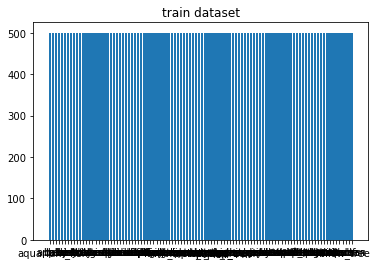

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


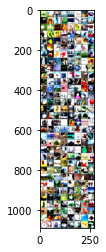

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


squirrel plain train  crab streetcar chair tiger pickup_truck mouse   bee skyscraper kangaroo couch lobster table streetcar hamster tulip bridge orange beetle beetle bicycle table woman  pear snake   bed   boy bridge flatfish  girl shrew  rose   ray couch streetcar plate  lion turtle  road plate chair   fox house telephone  baby   can maple_tree  pear chair lobster  tank shrew willow_tree telephone skyscraper  seal lawn_mower   man forest  baby  worm  crab mushroom  wolf cloud forest   bus clock  pear cattle possum apple cockroach beaver  girl motorcycle tulip skunk clock  seal  road pine_tree woman caterpillar   boy   man willow_tree dolphin poppy cockroach streetcar   sea poppy  bowl television chimpanzee porcupine bicycle   can  girl otter otter rocket pine_tree house  tank television raccoon caterpillar apple   bus  seal   can  lion wardrobe bridge  bowl plate aquarium_fish woman beaver shark  bowl bridge oak_tree cloud chimpanzee bridge cattle cloud   bee  baby   can bicycle dinos

Finished Training Epoch : 70  With the running loss :  1.0085735086883814
Finished testing
Finished Training Epoch : 71  With the running loss :  0.992062625836353
Finished testing
Finished Training Epoch : 72  With the running loss :  0.9713177982033515
Finished testing
Finished Training Epoch : 73  With the running loss :  0.9531498764242444
Finished testing
Finished Training Epoch : 74  With the running loss :  0.9307235613161203
Finished testing
Finished Training Epoch : 75  With the running loss :  0.9172669402798828
Finished testing
Finished Training Epoch : 76  With the running loss :  0.8930564103077869
Finished testing
Finished Training Epoch : 77  With the running loss :  0.8852234501011518
Finished testing
Finished Training Epoch : 78  With the running loss :  0.8634765677306117
Finished testing
Finished Training Epoch : 79  With the running loss :  0.8446578894342694
Finished testing
Finished Training Epoch : 80  With the running loss :  0.8267274249573143
Finished testing


Finished testing
Finished Training Epoch : 160  With the running loss :  0.1719200965777343
Finished testing
Finished Training Epoch : 161  With the running loss :  0.17359665062810695
Finished testing
Finished Training Epoch : 162  With the running loss :  0.16869519932233565
Finished testing
Finished Training Epoch : 163  With the running loss :  0.16961149783919052
Finished testing
Finished Training Epoch : 164  With the running loss :  0.16251636148259352
Finished testing
Finished Training Epoch : 165  With the running loss :  0.15993517181094802
Finished testing
Finished Training Epoch : 166  With the running loss :  0.1653695231949795
Finished testing
Finished Training Epoch : 167  With the running loss :  0.15719118832173404
Finished testing
Finished Training Epoch : 168  With the running loss :  0.15307060613924142
Finished testing
Finished Training Epoch : 169  With the running loss :  0.15052293457699062
Finished testing
Finished Training Epoch : 170  With the running loss : 

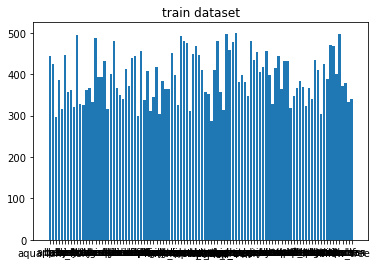

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


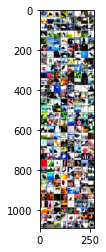

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


snake chimpanzee butterfly caterpillar   can hamster  girl skyscraper keyboard streetcar maple_tree lawn_mower woman train mushroom sweet_pepper chair house caterpillar trout   ray forest lobster porcupine spider snail camel skunk apple porcupine raccoon clock butterfly  tank dolphin   bee chimpanzee   can whale   bus mouse porcupine   sea whale woman   can   cup shark snail plate television chimpanzee orchid otter shark  lamp snake  seal motorcycle  seal sweet_pepper mushroom mouse  bear   bus turtle possum cockroach lawn_mower whale pine_tree pickup_truck plain tulip poppy streetcar  crab dinosaur oak_tree  rose clock snake bridge  lion  wolf plain wardrobe otter  wolf  baby  lamp   fox motorcycle lawn_mower rocket  bear dinosaur trout   man aquarium_fish table mushroom tiger streetcar skunk rabbit  road   ray mouse  lion beetle  road snake house aquarium_fish   ray  crab cloud  baby couch squirrel kangaroo beaver caterpillar motorcycle  crab spider train elephant apple possum wardro

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.906003216644386
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.6689479412970605
Finished testing
Finished Training Epoch : 3  With the running loss :  3.512282162517696
Finished testing
Finished Training Epoch : 4  With the running loss :  3.3906446555992225
Finished testing
Finished Training Epoch : 5  With the running loss :  3.2905898481220386
Finished testing
Finished Training Epoch : 6  With the running loss :  3.1900426443521073
Finished testing
Finished Training Epoch : 7  With the running loss :  3.1134695232688605
Finished testing
Finished Training Epoch : 8  With the running loss :  3.0411431015311905
Finished testing
Finished Training Epoch : 9  With the running loss :  2.9645352115878816
Finished testing
Finished Training Epoch : 10  With the running loss :  2.9008788365822333
Finished testing
Finished Training Epoch : 11  With the running loss :  2.8443808075669526
Finished testing
Finished Training Epoch : 12  With the running loss :  2.792430346662348
Finished testing
Finished 

Finished testing
Finished Training Epoch : 93  With the running loss :  0.6272696378556171
Finished testing
Finished Training Epoch : 94  With the running loss :  0.6121259591022089
Finished testing
Finished Training Epoch : 95  With the running loss :  0.6075424414563488
Finished testing
Finished Training Epoch : 96  With the running loss :  0.5996855611537958
Finished testing
Finished Training Epoch : 97  With the running loss :  0.5767958946042246
Finished testing
Finished Training Epoch : 98  With the running loss :  0.5594543210871809
Finished testing
Finished Training Epoch : 99  With the running loss :  0.5503009126170889
Finished testing
Finished Training Epoch : 100  With the running loss :  0.5307638680006005
Finished testing
Finished Training Epoch : 101  With the running loss :  0.5301888900530805
Finished testing
Finished Training Epoch : 102  With the running loss :  0.5160509274377454
Finished testing
Finished Training Epoch : 103  With the running loss :  0.503416316849

Finished testing
Finished Training Epoch : 182  With the running loss :  0.12661091320506937
Finished testing
Finished Training Epoch : 183  With the running loss :  0.11853654581037434
Finished testing
Finished Training Epoch : 184  With the running loss :  0.11800417115355467
Finished testing
Finished Training Epoch : 185  With the running loss :  0.11675037789557662
Finished testing
Finished Training Epoch : 186  With the running loss :  0.1175785373606078
Finished testing
Finished Training Epoch : 187  With the running loss :  0.11257461741469897
Finished testing
Finished Training Epoch : 188  With the running loss :  0.11071549791407276
Finished testing
Finished Training Epoch : 189  With the running loss :  0.11317246184720621
Finished testing
Finished Training Epoch : 190  With the running loss :  0.10630578719466538
Finished testing
Finished Training Epoch : 191  With the running loss :  0.10811919549649412
Finished testing
Finished Training Epoch : 192  With the running loss :

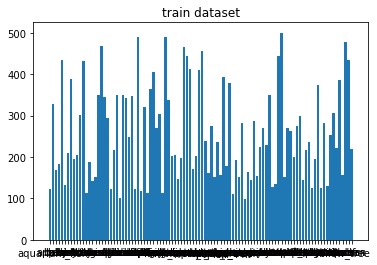

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


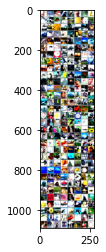

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


snake   cup bicycle skyscraper squirrel woman pine_tree  pear mouse skunk dinosaur clock kangaroo wardrobe  baby beaver palm_tree dinosaur   bee castle possum  tank trout  crab dolphin house  wolf beetle  tank  pear streetcar  wolf lizard woman couch tiger  seal snake mountain whale elephant beetle hamster rocket pine_tree   man  tank  wolf   cup lobster clock clock pickup_truck orange couch beaver caterpillar sunflower   boy telephone tiger porcupine castle whale table table   fox woman dolphin television couch otter lizard otter train sunflower   man mountain aquarium_fish  rose oak_tree  wolf keyboard castle spider hamster dinosaur woman cattle plain clock  lion mushroom table   boy lizard kangaroo   man mountain hamster mountain lobster dinosaur porcupine turtle tiger  pear   bee shrew  lion beaver dinosaur pine_tree dinosaur  seal clock raccoon tulip lobster streetcar plate lobster  pear cattle dinosaur clock cattle palm_tree caterpillar  baby keyboard snake  bear   fox   can fore

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  4.042492210274875
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.806525971629832
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.6487874252961414
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.5316219754738385
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.429672371042837
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.354692808472284
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  3.2813032121941594
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  3.211077040965014
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  3.1476369565076165
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  3.089585339668954
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  3.031782327312054
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.9802666347805813
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.9392967129697904
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.877921187051452
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.833462037662468
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.791515631250816
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.7559849082833456
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.7079989367192336
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.672595897523484
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.6345844528462625
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.5895101221481163
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  2.558971390865816
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  2.521220849292113
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  2.486896290637478
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  2.4537705360072675
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  2.4257025246572956
Finished testing
Finished Training Epoch : 27  With the running loss :  2.380677185436286
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  2.3586975371483536
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  2.3373994992511125
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  2.2964794682984304
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  2.2620461246754875
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  2.232169879545079
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  2.203117662137097
Finished testing
Finished Training Epoch : 34  With the running loss :  2.163146831021451
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  2.1322969611328437
Finished testing
Finished Training Epoch : 36  With the running loss :  2.1178216863386705
Finished testing
Finished Training Epoch : 37  With the running loss :  2.085204703973071
Finished testing
Finished Training Epoch : 38  With the running loss :  2.049495247330995
Finished testing
Finished Training Epoch : 39  With the running loss :  2.0098511228466975
Finished testing
Finished Training Epoch : 40  With the running loss :  1.988850204071196
Finished testing
Finished Training Epoch : 41  With the running loss :  1.9683890519755902
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.9344805325611982
Finished testing
Finished Training Epoch : 43  With the running loss :  1.9113401918127986
Finished testing
Finished Training Epoch : 44  With the running loss :  1.873359735649411
Finished testing
Finished Training Epoch : 45  With the running loss :  1.8478119101854835
Finished testing
Finished Training Epoch : 46  With the running loss :  1.82093877485483
Finished testing
Finished Training Epoch : 47  With the running loss :  1.7903013500836815
Finished testing
Finished Training Epoch : 48  With the running loss :  1.7571845231669965
Finished testing
Finished Training Epoch : 49  With the running loss :  1.724153726407797
Finished testing
Finished Training Epoch : 50  With the running loss :  1.7094857999593904
Finished testing
Finished Training Epoch : 51  With the running loss :  1.6733830317412273
Finished testing
Finished Training Epoch : 52  With the running loss :  1.6533783449985013
Finished testing
Fin

Finished testing
Finished Training Epoch : 132  With the running loss :  0.29440011703732005
Finished testing
Finished Training Epoch : 133  With the running loss :  0.2899948842454665
Finished testing
Finished Training Epoch : 134  With the running loss :  0.287985775435325
Finished testing
Finished Training Epoch : 135  With the running loss :  0.2780871376542761
Finished testing
Finished Training Epoch : 136  With the running loss :  0.2801484242819323
Finished testing
Finished Training Epoch : 137  With the running loss :  0.27296520046668477
Finished testing
Finished Training Epoch : 138  With the running loss :  0.26031635790178104
Finished testing
Finished Training Epoch : 139  With the running loss :  0.25381002523521384
Finished testing
Finished Training Epoch : 140  With the running loss :  0.2531092469349947
Finished testing
Finished Training Epoch : 141  With the running loss :  0.24654735373978567
Finished testing
Finished Training Epoch : 142  With the running loss :  0.2

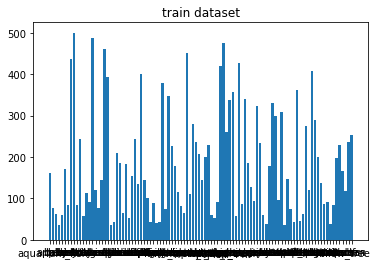

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


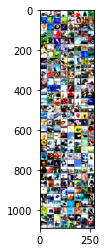

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


motorcycle skunk  pear lawn_mower butterfly woman pine_tree skunk whale butterfly shark poppy train woman  pear leopard woman skyscraper clock motorcycle flatfish mushroom pickup_truck crocodile palm_tree snake sweet_pepper elephant oak_tree raccoon  worm house butterfly chimpanzee rocket cattle dinosaur cloud streetcar streetcar woman   fox  bowl mouse castle plain tiger cattle trout apple mushroom house porcupine otter rocket caterpillar crocodile tractor snake skunk oak_tree skyscraper caterpillar willow_tree forest skyscraper skyscraper  lion forest elephant  wolf streetcar   cup poppy  worm mouse  lion skyscraper crocodile porcupine hamster plain couch shrew turtle clock pine_tree  tank couch whale dolphin house woman clock   boy  wolf bridge butterfly cattle  pear maple_tree telephone lobster  lamp  road palm_tree   boy apple wardrobe cockroach tractor shark tiger plate tiger streetcar telephone keyboard  road house whale bicycle keyboard telephone  baby apple hamster raccoon tig

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.9546669423580147
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.7044960293504925
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.529154794083701
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.3945345713032617
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.303838163614273
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.2181251645088196
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  3.133249749739965
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  3.063677685128318
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  3.0006079806221857
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.9407143957085085
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.8901430533991914
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.8369420866171517
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.791888011826409
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.7421322531170316
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.703784512148963
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.651294155253305
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.619095560577181
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.5835329757796393
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.531208326419194
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.498061931795544
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.4591317938433743
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  2.4289207690291934
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  2.3918147352006702
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  2.3539333343505864
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  2.3245332472854194
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  2.302722871303559
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  2.2485145462883827
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  2.222204175260332
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  2.1891726056734715
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  2.1605797525909214
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  2.1236338416735348
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  2.096606256233321
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  2.05616608262062
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  2.0418831821944985
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  2.005477436714702
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  1.965657255715794
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  1.9412914497984781
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  1.9121105488803651
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  1.8847190390030544
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  1.862933647301462
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  1.8148943533500035
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.8004677577151194
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  1.7614959842628903
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  1.7412336551480823
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  1.7094665351841187
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 46  With the running loss :  1.6729893485705059
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 47  With the running loss :  1.657153790195783
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  1.628499244650205
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 49  With the running loss :  1.5905683736006422
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 50  With the running loss :  1.5657840867837267
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 51  With the running loss :  1.5297507362233267
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 52  With the running loss :  1.5174990942080815
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 53  With the running loss :  1.4902932677004073
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 54  With the running loss :  1.4628202418486278
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 55  With the running loss :  1.4377472731802199
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 56  With the running loss :  1.4197108248869577
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 57  With the running loss :  1.3876202056805291
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 58  With the running loss :  1.3731346660190158
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 59  With the running loss :  1.3263809680938716
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 60  With the running loss :  1.3231999542978072
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 61  With the running loss :  1.2921171171797647
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 62  With the running loss :  1.2676151759094663
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 63  With the running loss :  1.2426739003923204
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 64  With the running loss :  1.2105584227376514
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 65  With the running loss :  1.197475971447097
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 66  With the running loss :  1.1701922648482852
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 67  With the running loss :  1.1380236612425905
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 68  With the running loss :  1.1171290501952167
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 69  With the running loss :  1.097400076687336
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 70  With the running loss :  1.0691329878237512
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 71  With the running loss :  1.0572568517592216
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 72  With the running loss :  1.0367709323763852
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 73  With the running loss :  1.0198877238565025
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 74  With the running loss :  1.0049628565708795
Finished testing
Finished Training Epoch : 75  With the running loss :  0.9610552108950086
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 76  With the running loss :  0.9496492817997932
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 77  With the running loss :  0.9195081517100334
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 78  With the running loss :  0.9129116932551066
Finished testing
Finished Training Epoch : 79  With the running loss :  0.8912659618589613
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 80  With the running loss :  0.8612186263004938
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 81  With the running loss :  0.853746857908037
Finished testing
Finished Training Epoch : 82  With the running loss :  0.83445812182294
Finished testing
Finished Training Epoch : 83  With the running loss :  0.8079607693685426
Finished testing
Finished Training Epoch : 84  With the running loss :  0.8045687360896004
Finished testing
Finished Training Epoch : 85  With the running loss :  0.7711746303571597
Finished testing
Finished Training Epoch : 86  With the running loss :  0.760174942513307
Finished testing
Finished Training Epoch : 87  With the running loss :  0.7290181790788969
Finished testing
Finished Training Epoch : 88  With the running loss :  0.7245068682564629
Finished testing
Finished Training Epoch : 89  With the running loss :  0.7048932885130248
Finished testing
Finished Training Epoch : 90  With the running loss :  0.6865469283527799
Finished testing
Finished Training Epoch : 91  With the running loss :  0.6822392866015434
Finished testing
Fin

Finished Training Epoch : 170  With the running loss :  0.13422413630824956
Finished testing
Finished Training Epoch : 171  With the running loss :  0.13146001214368475
Finished testing
Finished Training Epoch : 172  With the running loss :  0.13178900008400282
Finished testing
Finished Training Epoch : 173  With the running loss :  0.12830993460698265
Finished testing
Finished Training Epoch : 174  With the running loss :  0.12623789275272024
Finished testing
Finished Training Epoch : 175  With the running loss :  0.13412975292238918
Finished testing
Finished Training Epoch : 176  With the running loss :  0.13034617073006094
Finished testing
Finished Training Epoch : 177  With the running loss :  0.12430291208955976
Finished testing
Finished Training Epoch : 178  With the running loss :  0.1149029703810811
Finished testing
Finished Training Epoch : 179  With the running loss :  0.1179710194054577
Finished testing
Finished Training Epoch : 180  With the running loss :  0.11988539207312

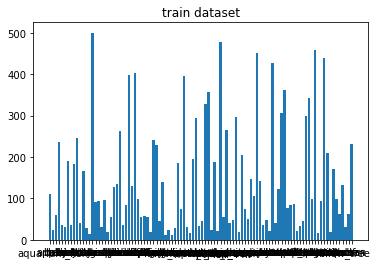

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


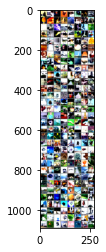

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


kangaroo television   boy butterfly table beaver orchid  tank plate   bee orchid  lion skyscraper mushroom possum oak_tree plate  tank cloud  road turtle shark palm_tree caterpillar porcupine   cup aquarium_fish skunk  tank  bear turtle  rose porcupine flatfish television trout   bee table leopard maple_tree wardrobe table beetle chimpanzee mushroom apple shrew cloud plate   fox   sea trout   bee rocket table   boy bridge pine_tree train elephant dinosaur shark mushroom  bear   boy maple_tree tractor dinosaur shark rabbit table   boy  tank wardrobe oak_tree willow_tree   can  wolf plate skyscraper palm_tree pickup_truck turtle cloud  road mushroom lizard  tank table couch lizard motorcycle couch  bear  girl porcupine   bee mouse clock  worm tractor  road television train hamster palm_tree   bus oak_tree   fox palm_tree  girl   cup apple camel cloud lizard apple palm_tree lizard  bear whale   boy skyscraper  baby crocodile  tank bottle rocket pickup_truck  lamp shark  road lizard skunk 

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.8952483567324547
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.647666311264038
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.4854143706235017
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.3538519685918633
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.254224508458918
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.1824837251143028
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  3.1069246248765423
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  3.027667392383923
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  2.971565094861117
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.8913946975361218
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.838317363912409
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.7852004181254992
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.731630953875455
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.6741749503395775
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.628538465499878
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.5992375287142666
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.545974601398815
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.5037555824626576
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.4790914232080636
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.42571534243497
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.3907147884368896
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  2.3521523995832965
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  2.3165232441642076
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  2.2877165534279555
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  2.247703006050803
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  2.2064386324449017
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  2.1782972856001424
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  2.1470233982259583
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  2.131958270072938
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  2.0945408214222296
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  2.057134714993564
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  2.0187110120599927
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  2.0080344373529604
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  1.9745127938010476
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  1.9393955729224466
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  1.9223730715838345
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  1.8865255117416382
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  1.8648173440586437
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  1.83282067342238
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  1.8021989583969116
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  1.7848811279643666
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.7486082640561191
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  1.7293762575496328
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  1.6946461395783858
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  1.6673695455897939
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 46  With the running loss :  1.6471890861337835
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 47  With the running loss :  1.616449737548828
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  1.579656199975447
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 49  With the running loss :  1.560970232703469
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 50  With the running loss :  1.5533942677757957
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 51  With the running loss :  1.5231868462129072
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 52  With the running loss :  1.4899626124988903
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 53  With the running loss :  1.466701533577659
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 54  With the running loss :  1.4327942154624242
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 55  With the running loss :  1.4063822767951273
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 56  With the running loss :  1.3866932760585438
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 57  With the running loss :  1.3672155098481606
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 58  With the running loss :  1.3549102197993885
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 59  With the running loss :  1.3145707715641368
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 60  With the running loss :  1.2961606849323621
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 61  With the running loss :  1.2604719053615223
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 62  With the running loss :  1.2432223883542142
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 63  With the running loss :  1.224589271978898
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 64  With the running loss :  1.207186655564741
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 65  With the running loss :  1.1735764568502254
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 66  With the running loss :  1.1482194055210455
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 67  With the running loss :  1.1272451595826585
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 68  With the running loss :  1.1022813287648285
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 69  With the running loss :  1.1001256465911866
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 70  With the running loss :  1.0709766333753417
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 71  With the running loss :  1.0455635049126364
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 72  With the running loss :  1.0200635129755193
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 73  With the running loss :  1.018748740716414
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 74  With the running loss :  0.9889829223806208
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 75  With the running loss :  0.9668474121527239
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 76  With the running loss :  0.9447956323623657
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 77  With the running loss :  0.9395645022392273
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 78  With the running loss :  0.899789653041146
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 79  With the running loss :  0.8832368373870849
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 80  With the running loss :  0.8743359110572121
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 81  With the running loss :  0.8547291874885559
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 82  With the running loss :  0.8266748038205234
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 83  With the running loss :  0.812823415886272
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 84  With the running loss :  0.8029823249036615
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 85  With the running loss :  0.7766853722659024
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 86  With the running loss :  0.7656111478805542
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 87  With the running loss :  0.7428483085198836
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 88  With the running loss :  0.7260655879974365
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 89  With the running loss :  0.709193200414831
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 90  With the running loss :  0.6963452545079318
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 91  With the running loss :  0.6900267871943384
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 92  With the running loss :  0.6863532456484708
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 93  With the running loss :  0.6460079182278026
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 94  With the running loss :  0.6268555326895283
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 95  With the running loss :  0.6166381418704987
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 96  With the running loss :  0.6172799576412549
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 97  With the running loss :  0.6012465525757182
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 98  With the running loss :  0.590980347178199
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 99  With the running loss :  0.574277323484421
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 100  With the running loss :  0.5451791817491705
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 101  With the running loss :  0.5459380518306386
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 102  With the running loss :  0.5448264739730141
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 103  With the running loss :  0.5215668120167474
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 104  With the running loss :  0.5111250118775802
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 105  With the running loss :  0.494732878966765
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 106  With the running loss :  0.47956779490817675
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 107  With the running loss :  0.4777386643669822
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 108  With the running loss :  0.46679172028194776
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 109  With the running loss :  0.45217839533632453
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 110  With the running loss :  0.4511464969678359
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 111  With the running loss :  0.43516658490354365
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 112  With the running loss :  0.4421795563264327
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 113  With the running loss :  0.43041271242228424
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 114  With the running loss :  0.4137228413061662
Finished testing
Finished Training Epoch : 115  With the running loss :  0.39533578103238887
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 116  With the running loss :  0.38601943362842905
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 117  With the running loss :  0.37531599294055584
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 118  With the running loss :  0.37713057290424
Finished testing
Finished Training Epoch : 119  With the running loss :  0.3722325086593628
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 120  With the running loss :  0.35324337753382595
Finished testing
Finished Training Epoch : 121  With the running loss :  0.35117421962998124
Finished testing
Finished Training Epoch : 122  With the running loss :  0.3374827119437131
Finished testing
Finished Training Epoch : 123  With the running loss :  0.32504614158110184
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 124  With the running loss :  0.33174523684111507
Finished testing
Finished Training Epoch : 125  With the running loss :  0.3171333410523155
Finished testing
Finished Training Epoch : 126  With the running loss :  0.31492324390194626
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 127  With the running loss :  0.3103887633843856
Finished testing
Finished Training Epoch : 128  With the running loss :  0.31138673397627736
Finished testing
Finished Training Epoch : 129  With the running loss :  0.28300383714112365
Finished testing
Finished Training Epoch : 130  With the running loss :  0.28775959258729755
Finished testing
Finished Training Epoch : 131  With the running loss :  0.28078935796564275
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 132  With the running loss :  0.2812222529541362
Finished testing
Finished Training Epoch : 133  With the running loss :  0.27093556902625354
Finished testing
Finished Training Epoch : 134  With the running loss :  0.2773065073923631
Finished testing
Finished Training Epoch : 135  With the running loss :  0.26518219357187095
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 136  With the running loss :  0.258516094901345
Finished testing
Finished Training Epoch : 137  With the running loss :  0.2443647563457489
Finished testing
Finished Training Epoch : 138  With the running loss :  0.2476091899655082
Finished testing
Finished Training Epoch : 139  With the running loss :  0.23910536820238287
Finished testing
Finished Training Epoch : 140  With the running loss :  0.2418732001022859
Finished testing
Finished Training Epoch : 141  With the running loss :  0.22769221338358792
Finished testing
Finished Training Epoch : 142  With the running loss :  0.23021564537828618
Finished testing
Finished Training Epoch : 143  With the running loss :  0.21331958255984568
Finished testing
Finished Training Epoch : 144  With the running loss :  0.21722925196994436
Finished testing
Finished Training Epoch : 145  With the running loss :  0.22189398949796504
Finished testing
Finished Training Epoch : 146  With the running loss :  0.2050423340363936


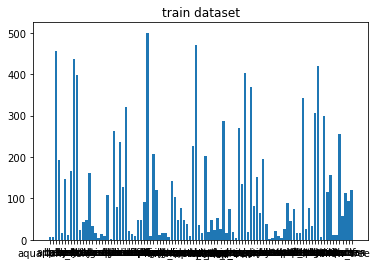

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


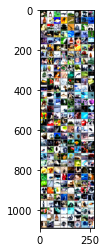

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


  fox bottle squirrel whale bicycle clock  lamp elephant bottle  pear trout beetle  worm raccoon maple_tree turtle flatfish bicycle bicycle maple_tree lizard television bridge raccoon   fox   fox  tank   bus cloud chimpanzee motorcycle mushroom bicycle beaver   fox possum bottle  rose motorcycle cloud tiger couch turtle tiger dinosaur orange motorcycle train television tiger   cup tiger tractor  bear maple_tree  pear  baby mushroom  baby possum porcupine couch squirrel couch pine_tree  pear possum snake   bus flatfish bicycle possum maple_tree raccoon   fox keyboard flatfish whale maple_tree flatfish train tulip  baby cloud  rose   fox  lamp couch couch television chimpanzee  bear motorcycle bicycle clock  worm bicycle flatfish elephant trout  bear couch whale cockroach chimpanzee television couch possum raccoon motorcycle tulip sweet_pepper mushroom tulip plain elephant   bed bicycle train flatfish sweet_pepper  baby motorcycle   bus dolphin  baby whale flatfish train possum sweet_pep

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  3.898964582487594
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  3.6296442553054455
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  3.4456438741018607
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  3.3194987940233807
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  3.19613315892774
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  3.1040555155554483
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  3.03380319129589
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  2.960743138956469
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  2.8891831608705747
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  2.8355834428654165
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  2.770833015441894
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  2.728765775991041
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  2.6735485542652215
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  2.6354750810667524
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  2.581262289091598
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  2.5403262404508364
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  2.5080001631448434
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  2.4566976026047107
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  2.4307058023851966
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  2.3756246455880095
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  2.3423118813093313
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  2.3083852058233214
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  2.2857914331347438
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  2.2624979407288315
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  2.2160394773926844
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  2.184939401094303
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  2.153822616089223
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  2.1129136251848792
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  2.104333614194116
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  2.0592606954796375
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  2.031864274379819
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  2.014911033386408
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  1.9681075201478115
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  1.9532187151354412
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  1.9020476119462835
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  1.8867033082385396
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  1.8621993203495824
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  1.8235860397649366
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  1.80944305519725
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  1.7847629646922267
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  1.7538543800975002
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  1.717580146567766
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  1.7013167752776035
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  1.669899541278218
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  1.6589638022489326
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 46  With the running loss :  1.6228929564010266
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 47  With the running loss :  1.6074736423270648
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  1.5828511964443117
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 49  With the running loss :  1.548104020052178
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 50  With the running loss :  1.5329993935518489
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 51  With the running loss :  1.498373106468556
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 52  With the running loss :  1.471791092739549
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 53  With the running loss :  1.4376329987548118
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 54  With the running loss :  1.4178219479183818
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 55  With the running loss :  1.4011734252752257
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 56  With the running loss :  1.3723467255747595
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 57  With the running loss :  1.3619998499404549
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 58  With the running loss :  1.334569149239119
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 59  With the running loss :  1.3065830829531648
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 60  With the running loss :  1.2701727096424549
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 61  With the running loss :  1.281673137531724
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 62  With the running loss :  1.2333298006723097
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 63  With the running loss :  1.2320467594058016
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 64  With the running loss :  1.1858854376992516
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 65  With the running loss :  1.1888506662013918
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 66  With the running loss :  1.1499356752218204
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 67  With the running loss :  1.1259572076243023
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 68  With the running loss :  1.1134420508562135
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 69  With the running loss :  1.0991498481395638
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 70  With the running loss :  1.0685941272003705
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 71  With the running loss :  1.0560713784639226
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 72  With the running loss :  1.037399523479994
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 73  With the running loss :  1.015983986300091
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 74  With the running loss :  0.9943998566893644
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 75  With the running loss :  0.9824759170066478
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 76  With the running loss :  0.9643847276998121
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 77  With the running loss :  0.9443915361581847
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 78  With the running loss :  0.9173967602641083
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 79  With the running loss :  0.9156981263049814
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 80  With the running loss :  0.8762581902881001
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 81  With the running loss :  0.8663084964419521
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 82  With the running loss :  0.8398568242095238
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 83  With the running loss :  0.8245481502178104
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 84  With the running loss :  0.818282731743746
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 85  With the running loss :  0.7956110169721204
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 86  With the running loss :  0.7702268666999285
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 87  With the running loss :  0.7507506345593652
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 88  With the running loss :  0.7407231150671495
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 89  With the running loss :  0.732274932916774
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 90  With the running loss :  0.7187855548636857
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 91  With the running loss :  0.7075754598129628
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 92  With the running loss :  0.6888978023861732
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 93  With the running loss :  0.6726131647132165
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 94  With the running loss :  0.6551588510358057
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 95  With the running loss :  0.632949783358463
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 96  With the running loss :  0.630875815485799
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 97  With the running loss :  0.613655969154003
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 98  With the running loss :  0.5999657282995623
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 99  With the running loss :  0.6022781403951865
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 100  With the running loss :  0.575965678969095
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 101  With the running loss :  0.5749231951181277
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 102  With the running loss :  0.5482463316861974
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 103  With the running loss :  0.5403380324674207
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 104  With the running loss :  0.5158583279265913
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 105  With the running loss :  0.520351500705231
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 106  With the running loss :  0.4854892561602038
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 107  With the running loss :  0.5009447946104892
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 108  With the running loss :  0.4795757234096527
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 109  With the running loss :  0.47383935992107834
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 110  With the running loss :  0.46175116716429243
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 111  With the running loss :  0.4457931255185327
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 112  With the running loss :  0.4429702051850252
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 113  With the running loss :  0.4406125781147979
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 114  With the running loss :  0.42571784313334976
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 115  With the running loss :  0.41082619095957557
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 116  With the running loss :  0.41566740634829497
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 117  With the running loss :  0.3966916224291158
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 118  With the running loss :  0.3936153054237366
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 119  With the running loss :  0.37063719158948855
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 120  With the running loss :  0.39230861705403
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 121  With the running loss :  0.37679973175359327
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 122  With the running loss :  0.35346862396528556
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 123  With the running loss :  0.34655182236848875
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 124  With the running loss :  0.3362951195517251
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 125  With the running loss :  0.3274918260962464
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 126  With the running loss :  0.3243510341921518
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 127  With the running loss :  0.3334927919299103
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 128  With the running loss :  0.31210376114346255
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 129  With the running loss :  0.31327195430910865
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 130  With the running loss :  0.31383291060148283
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 131  With the running loss :  0.29845601043035824
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 132  With the running loss :  0.3009610134501789
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 133  With the running loss :  0.28805361272290697
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 134  With the running loss :  0.2757390900406726
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 135  With the running loss :  0.26282367214213953
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 136  With the running loss :  0.2749596158432406
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 137  With the running loss :  0.25766576791918555
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 138  With the running loss :  0.2567645422247953
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 139  With the running loss :  0.24548675154530725
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 140  With the running loss :  0.24296092016752377
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 141  With the running loss :  0.2411776992470719
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 142  With the running loss :  0.24616591493750728
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 143  With the running loss :  0.22789960337239643
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 144  With the running loss :  0.22898801156254703
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 145  With the running loss :  0.2289693005556284
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 146  With the running loss :  0.21147395739721697
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 147  With the running loss :  0.21889940181443857
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 148  With the running loss :  0.20825696719247244
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 149  With the running loss :  0.2030096660519755
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 150  With the running loss :  0.20159871079200922
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 151  With the running loss :  0.20597486613794816
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 152  With the running loss :  0.20269334870715475
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 153  With the running loss :  0.1878414032764213
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 154  With the running loss :  0.19114317589027938
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 155  With the running loss :  0.1828349334902542
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 156  With the running loss :  0.17825595445411146
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 157  With the running loss :  0.17723831811616586
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 158  With the running loss :  0.1770054762100064
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 159  With the running loss :  0.17564997683430827
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 160  With the running loss :  0.17447627041228983
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 161  With the running loss :  0.18158490747906436
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 162  With the running loss :  0.1624116431488547
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 163  With the running loss :  0.16803970811671992
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 164  With the running loss :  0.16704585299242375
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 165  With the running loss :  0.161101562859014
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 166  With the running loss :  0.1578722383047259
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 167  With the running loss :  0.1483169438880543
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 168  With the running loss :  0.1546043278866036
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 169  With the running loss :  0.14537119033724763
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 170  With the running loss :  0.14698024960451347
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 171  With the running loss :  0.1411870393988698
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 172  With the running loss :  0.13348568248194315
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 173  With the running loss :  0.13828835861627445
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 174  With the running loss :  0.13060419815917348
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 175  With the running loss :  0.12340714054745297
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 176  With the running loss :  0.1274422958146694
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 177  With the running loss :  0.1276902114582616
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 178  With the running loss :  0.12458122019157854
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 179  With the running loss :  0.12530422921097553
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 180  With the running loss :  0.1162590434731439
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 181  With the running loss :  0.12347083330847496
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 182  With the running loss :  0.12093655713075815
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 183  With the running loss :  0.11924438126558483
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 184  With the running loss :  0.11300083301788152
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 185  With the running loss :  0.11775383110656294
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 186  With the running loss :  0.10658110452945842
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 187  With the running loss :  0.11339896882689277
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 188  With the running loss :  0.11556818093671355
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 189  With the running loss :  0.1104812050281569
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 190  With the running loss :  0.10769486912461214
Finished testing
Finished Training Epoch : 191  With the running loss :  0.10379391614087795
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 192  With the running loss :  0.09992368952479473
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 193  With the running loss :  0.09957687192878058
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 194  With the running loss :  0.09815066862244938
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 195  With the running loss :  0.10055490947046945
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 196  With the running loss :  0.09746065302643665
Finished testing
Finished Training Epoch : 197  With the running loss :  0.09111051183453826
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 198  With the running loss :  0.09623874412026516
Finished testing
Finished Training Epoch : 199  With the running loss :  0.09270976899668228
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar100_LA = []

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])


batch_size = 256

for lamda in [1.0, 0.995, 0.985, 0.975, 0.965, 0.955]:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    trainset, priori = long_tail_priori(trainset, len(trainset.classes), lamda)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(100, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = LogitAdjustedLoss(priori=torch.tensor(priori).cuda())
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=200)
    logs_by_lamda_resnet18_cifar100_LA.append({lamda: logs})

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  1.0


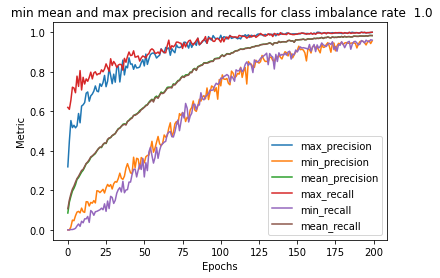

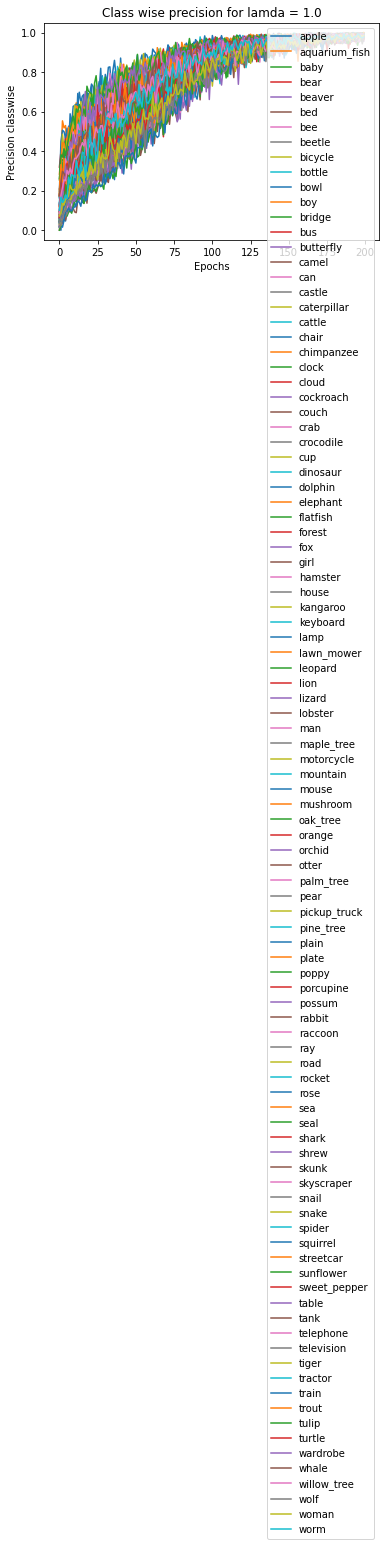

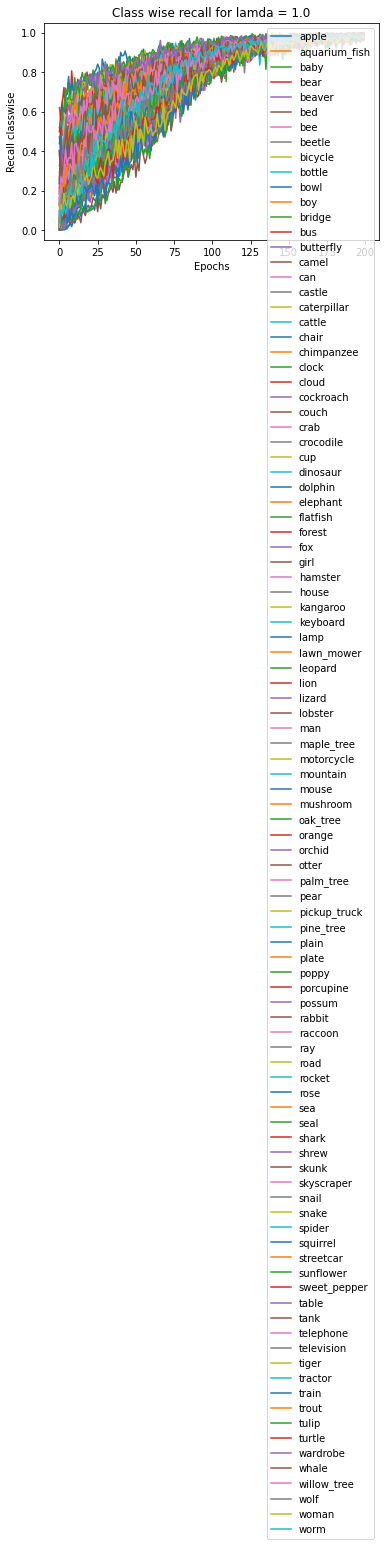

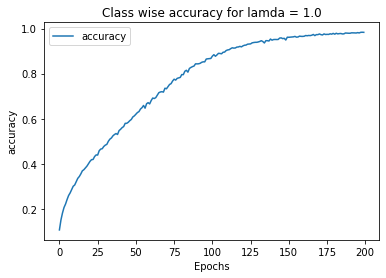

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.995


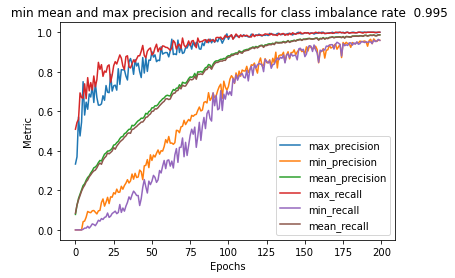

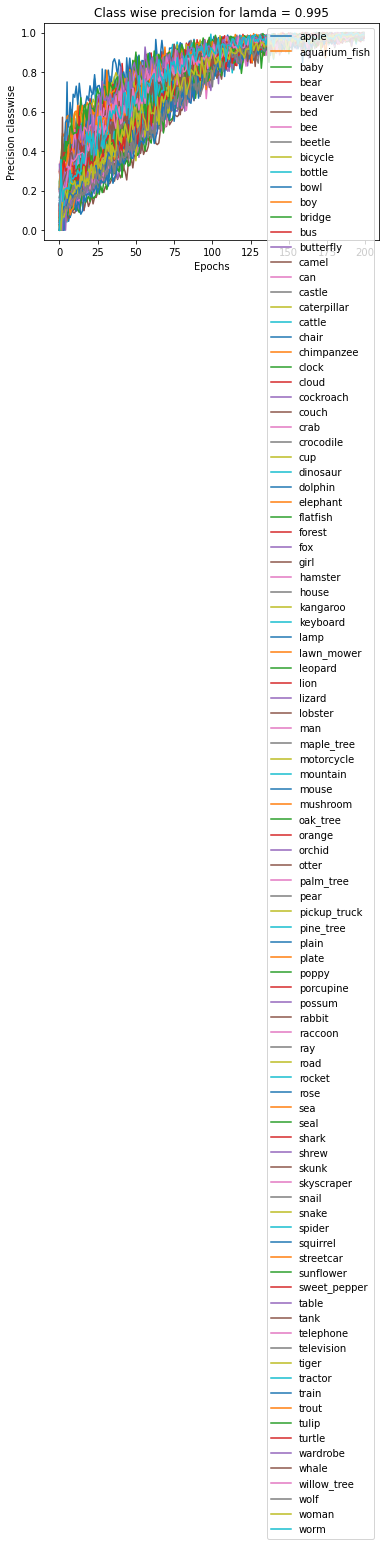

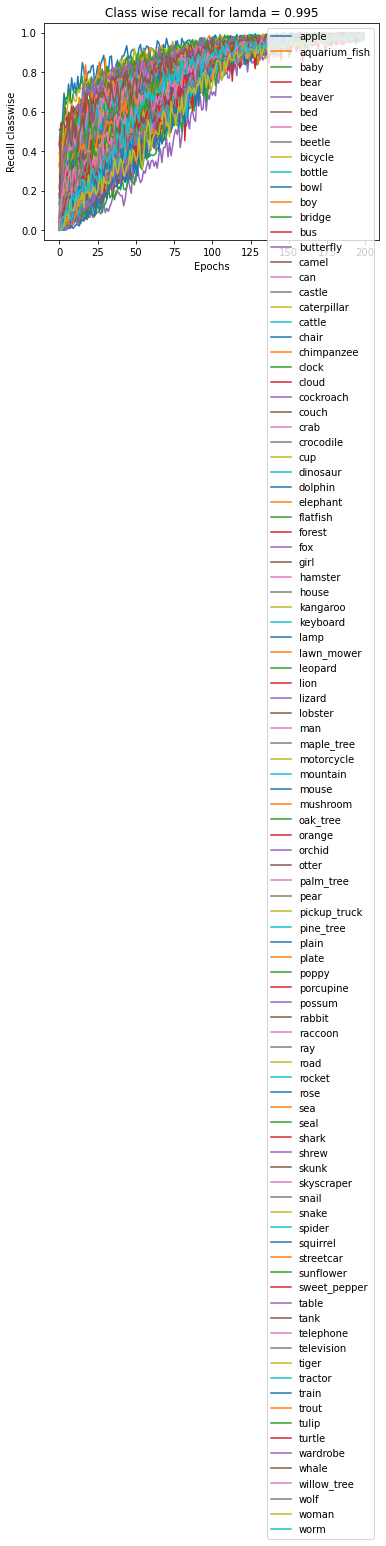

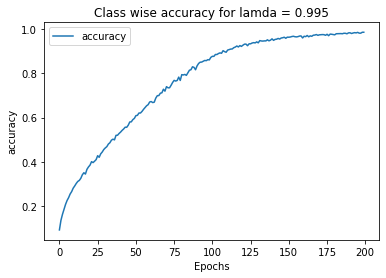

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.985


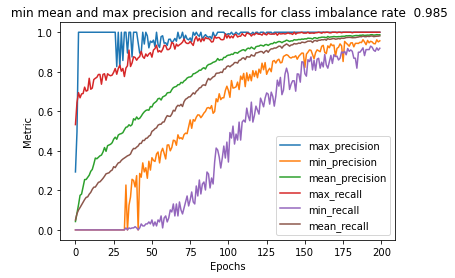

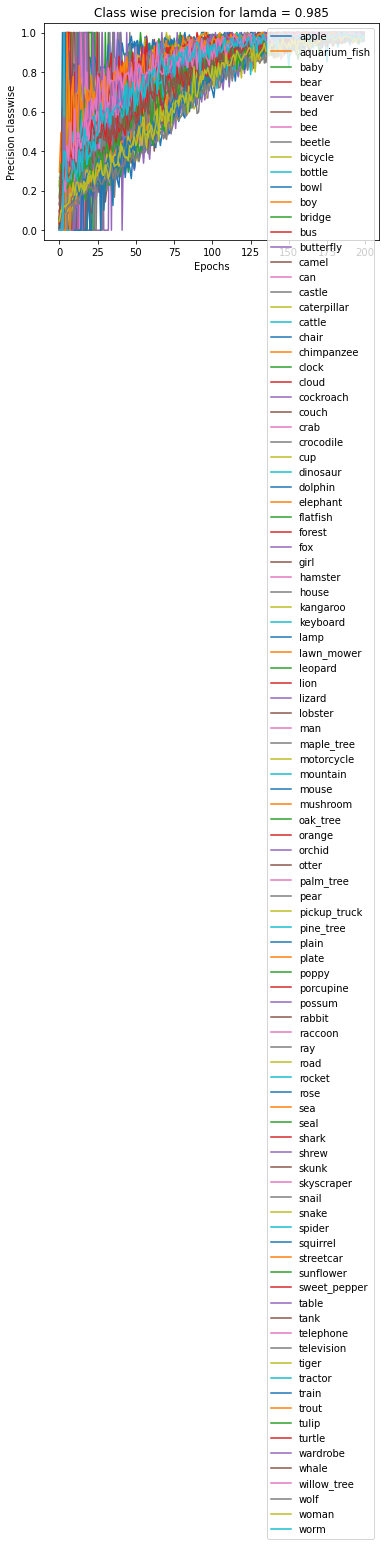

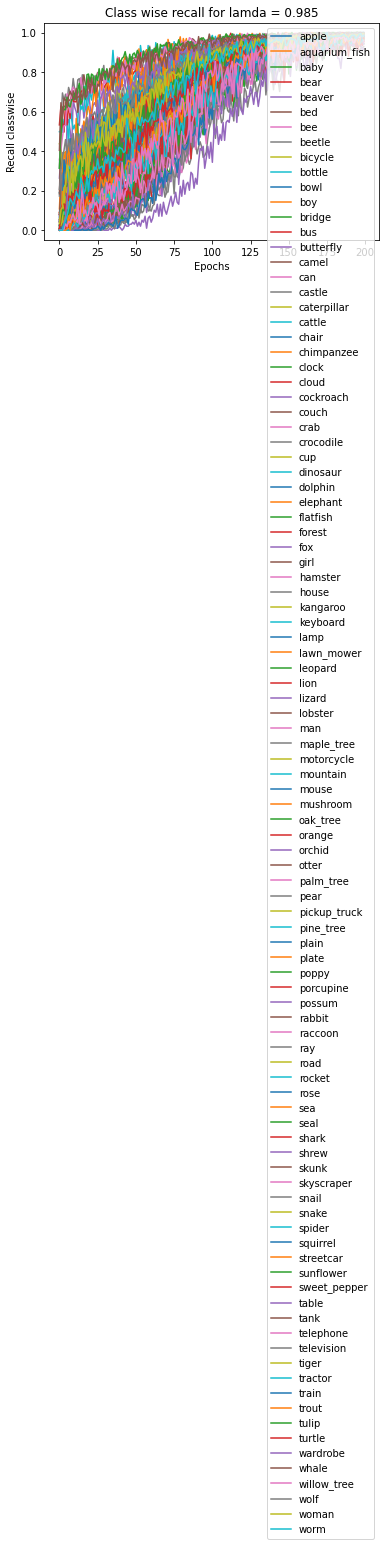

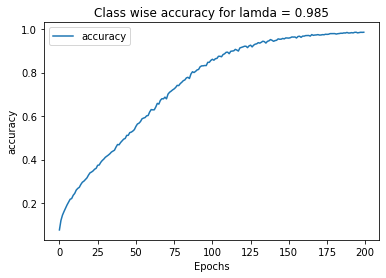

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.975


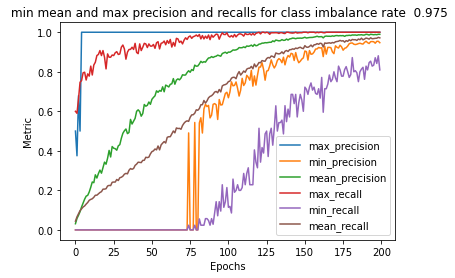

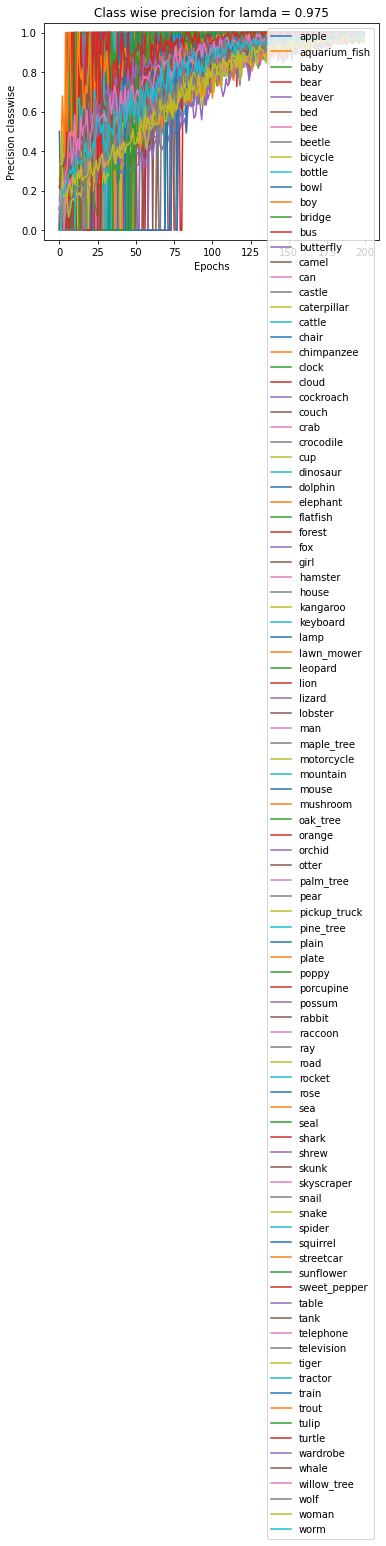

In [ ]:
for log in logs_by_lamda_resnet18_cifar100_LA:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER")
    print("THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)